# Handling of NaNs and Outliers

In [17]:
import os
import sys

sys.path.append('..')

import json
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import scipy.stats as stats

from scipy.spatial.distance import jensenshannon
from scipy.stats import wasserstein_distance

from utils.functions.normalize_string import normalize_string

In [8]:
local_folder = "/Users/massimilianoarca/Documents/PoliMi/Research Grant/SafeCREW/Data/Tarragona"
utils_folder = os.path.join('..', "utils")

clean_data_folder = os.path.join(local_folder, "Clean Data")

# Load Data

In [6]:
eb0_features_lab_df = pd.read_excel(
    os.path.join(clean_data_folder, "EB0_Features_Lab.xlsx")
)

eb0_targets_lab_df = pd.read_excel(
    os.path.join(clean_data_folder, "EB0_Targets_Lab.xlsx")
)

In [7]:
eb1_features_lab_df = pd.read_excel(
    os.path.join(clean_data_folder, "EB1_Features_Lab.xlsx")
)

eb1_targets_lab_df = pd.read_excel(
    os.path.join(clean_data_folder, "EB1_Targets_Lab.xlsx")
)

In [8]:
eb0_sensor_df = pd.read_excel(
    os.path.join(clean_data_folder, "EB0_Sensor.xlsx")
)

In [9]:
eb1_sensor_df = pd.read_excel(
    os.path.join(clean_data_folder, "EB1_Sensor.xlsx")
)

In [10]:
thms_df = pd.read_excel(os.path.join(clean_data_folder, "THMs.xlsx"))

In [ ]:
# import feature mappings
with open(os.path.join(utils_folder, 'mappings', "eb0_features_mapping.json")) as f:
    eb0_features_mapping = json.load(f)
    
with open(os.path.join(utils_folder, 'mappings', "eb1_features_mapping.json")) as f:
    eb1_features_mapping = json.load(f)

# Data Imputation

In [11]:
eb0_features_lab_df.columns = [
    normalize_string(c) for c in eb0_features_lab_df.columns
]

eb0_features_mapping = {
    normalize_string(k): v for k, v in eb0_features_mapping.items()
}

# Lab

## EB0

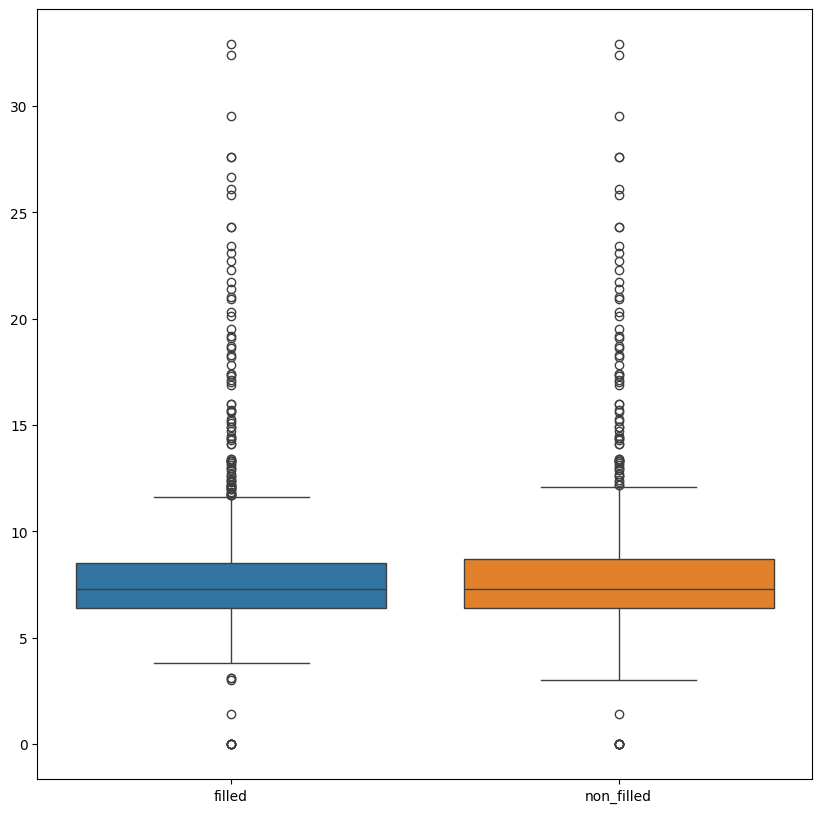

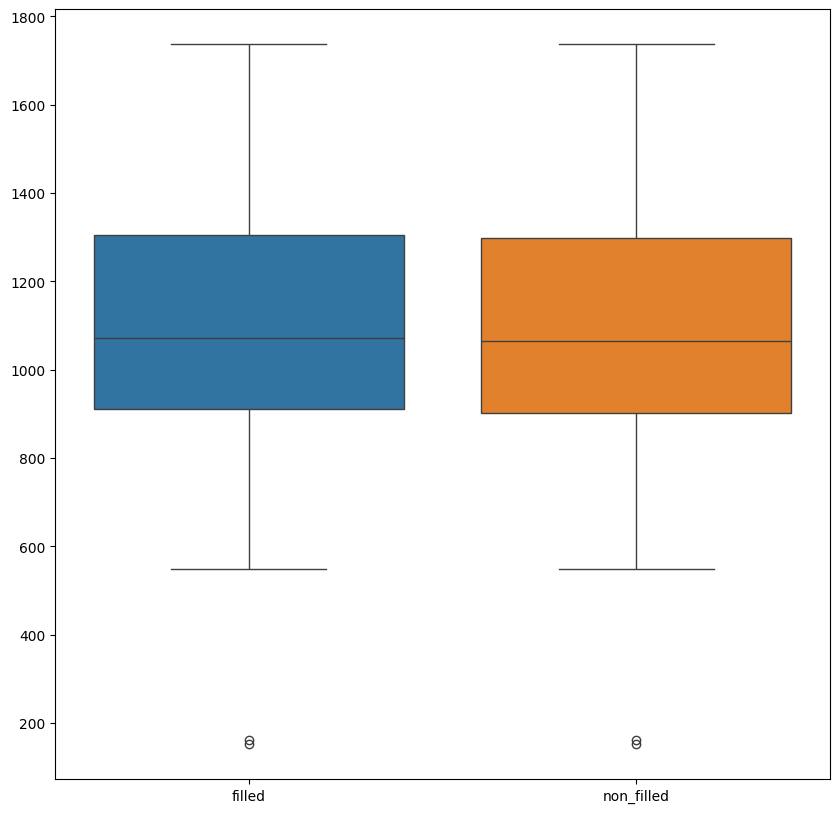

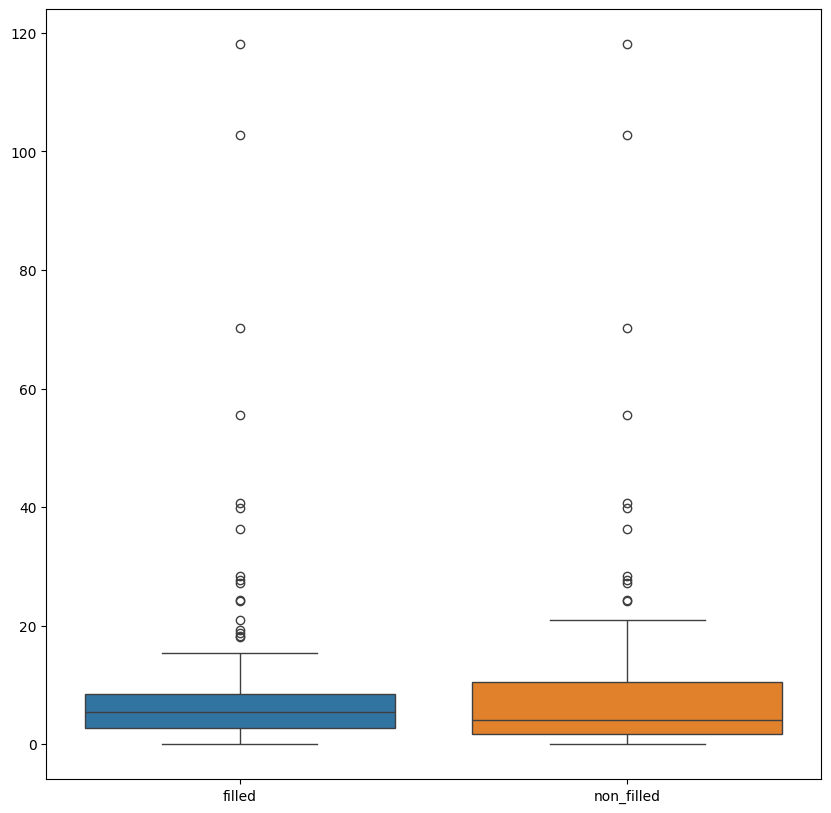

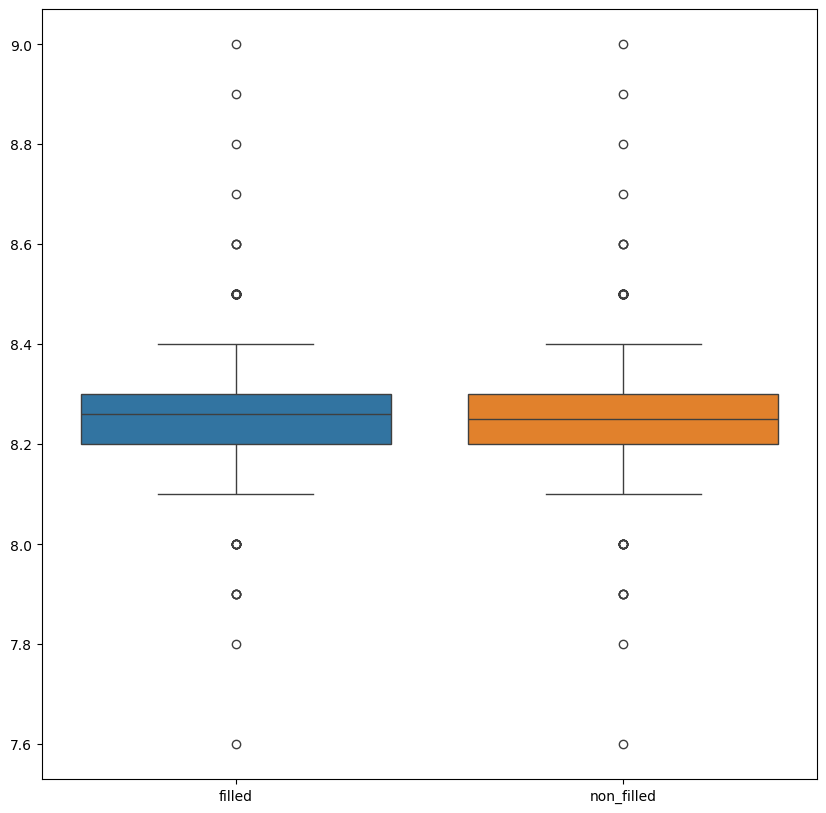

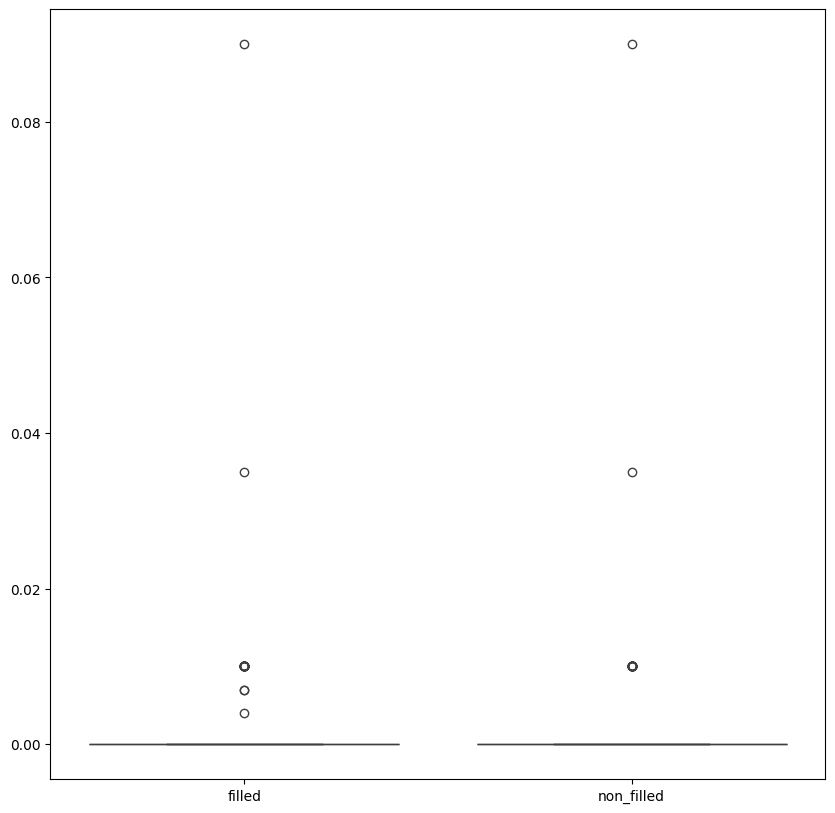

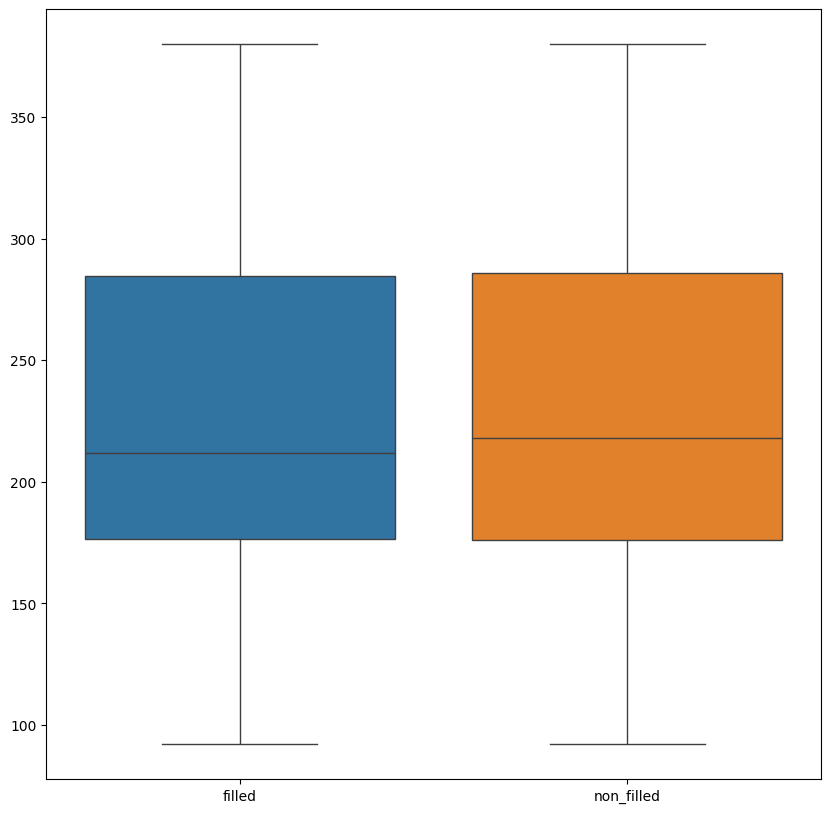

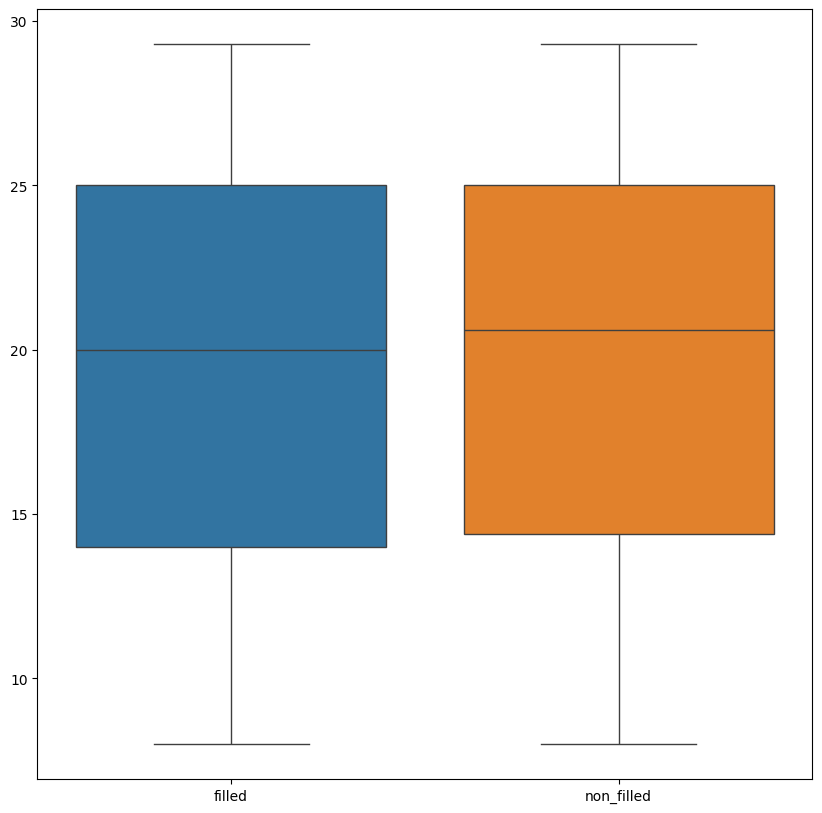

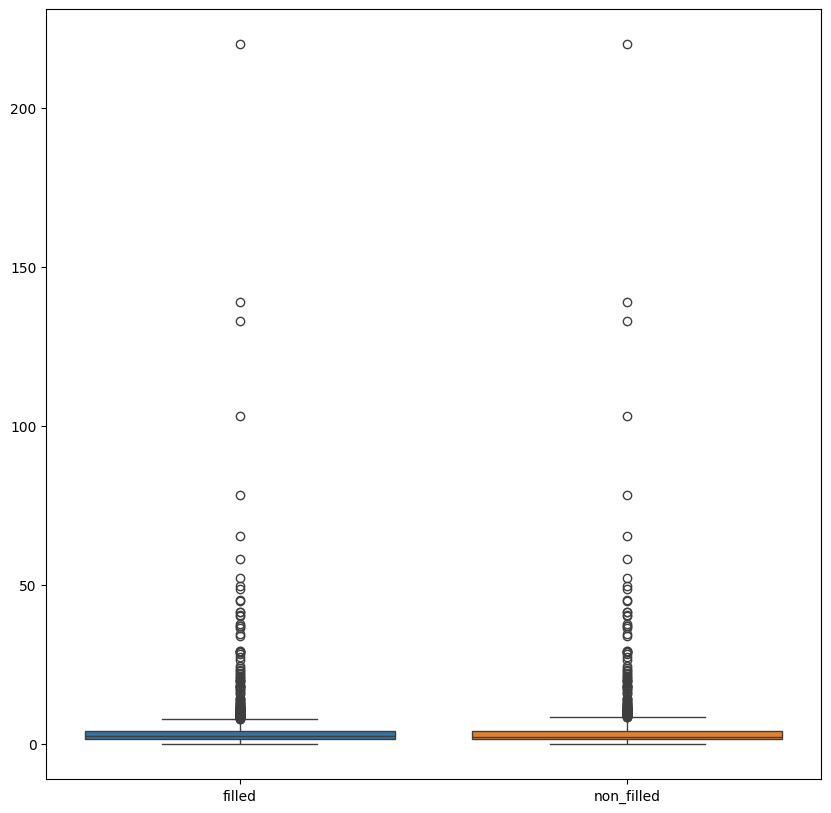

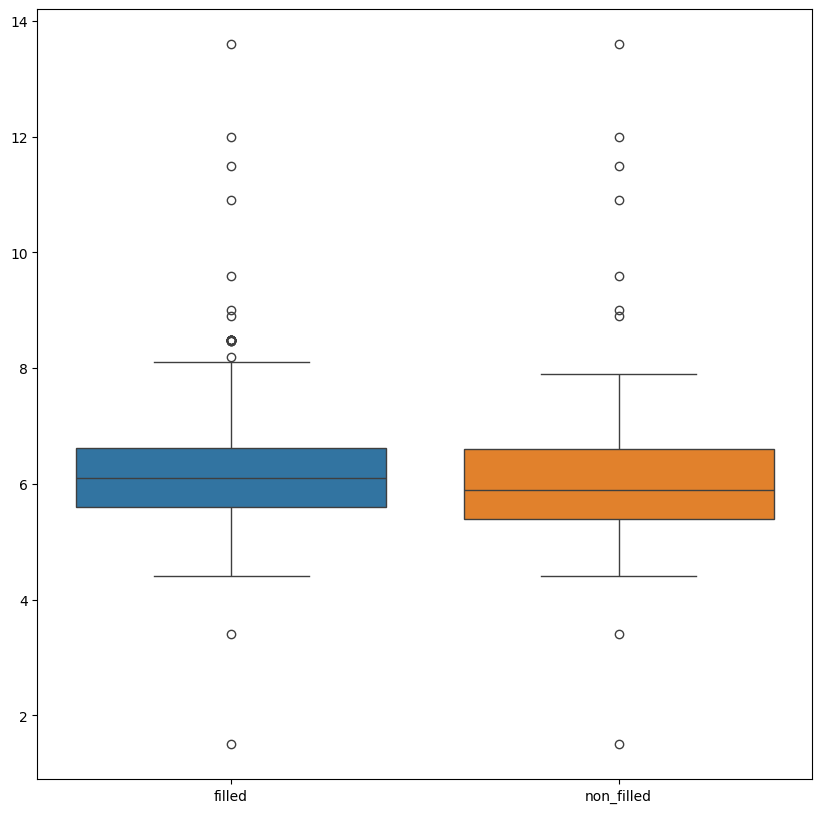

In [14]:
from sklearn.impute import KNNImputer

# Exclude 'DateTime' column
eb0_features_lab_df_numeric = eb0_features_lab_df.drop(columns="DateTime")

# Create a KNNImputer
imputer = KNNImputer(n_neighbors=5)

# Perform K-NN imputation
eb0_features_lab_df_filled = imputer.fit_transform(eb0_features_lab_df_numeric)

# Convert the result back to a DataFrame
eb0_features_lab_df_filled = pd.DataFrame(
    eb0_features_lab_df_filled,
    columns=eb0_features_lab_df_numeric.columns,
    index=eb0_features_lab_df_numeric.index,
)

# Add the 'DateTime' column back
eb0_features_lab_df_filled["DateTime"] = eb0_features_lab_df["DateTime"]

for lab_key in eb0_features_mapping.keys():
    plt.figure(figsize=(10, 10))

    temp_df = pd.DataFrame(
        {
            "filled": eb0_features_lab_df_filled[lab_key],
            "non_filled": eb0_features_lab_df[lab_key],
        }
    )

    sns.boxplot(data=temp_df)
    plt.show()

# Sensor

### Data Cleaning

#### Remove invalid samples

In [49]:
eb0_sensor_df = eb0_sensor_df[eb0_sensor_df["ALARMA ESPECTRAL"] < 3]

#### Remove Outliers

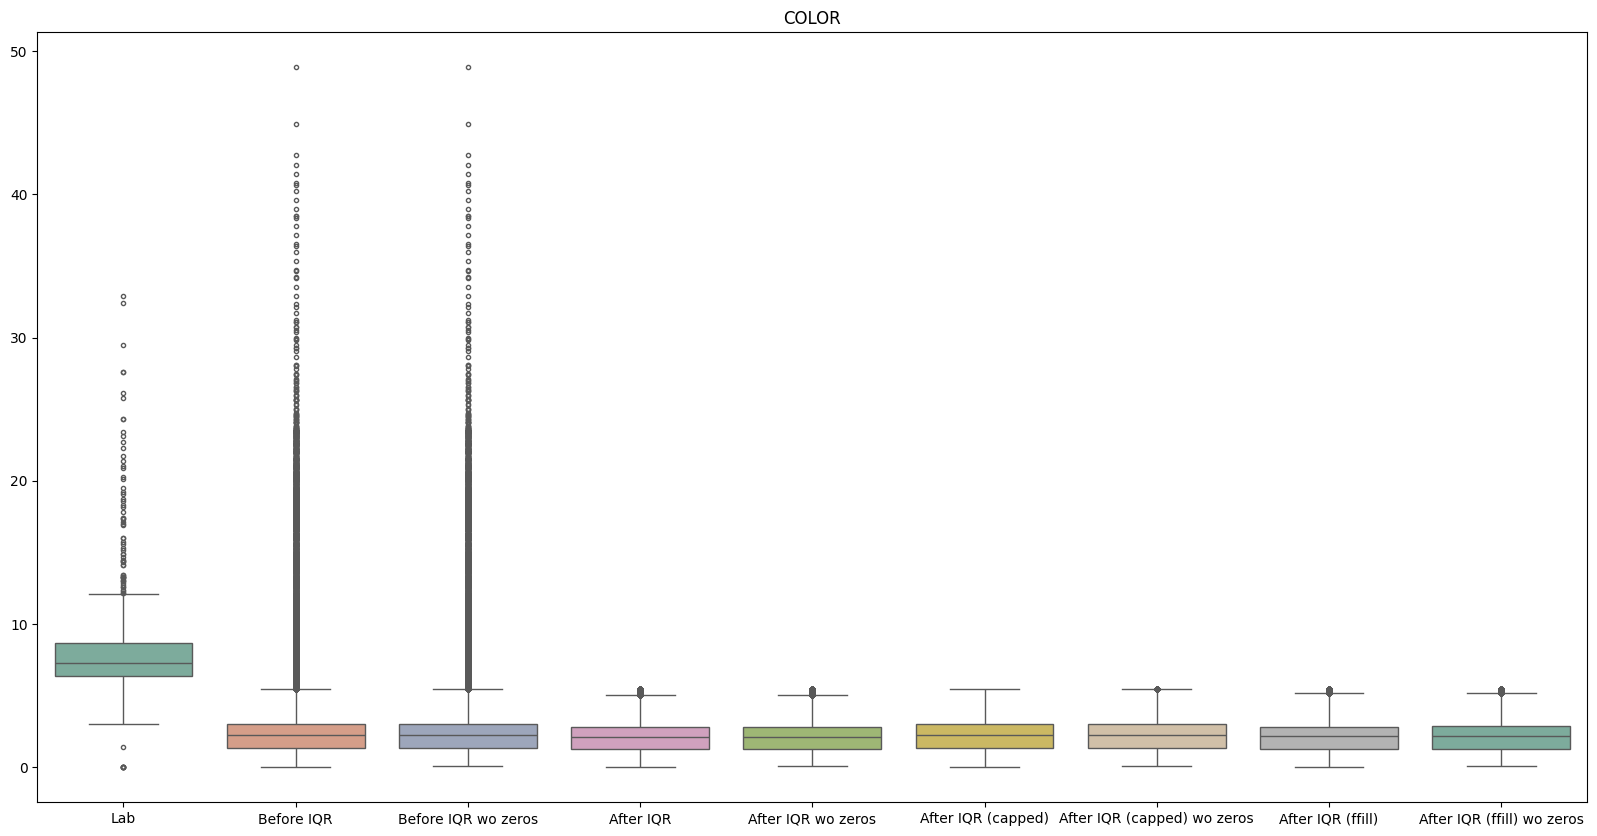

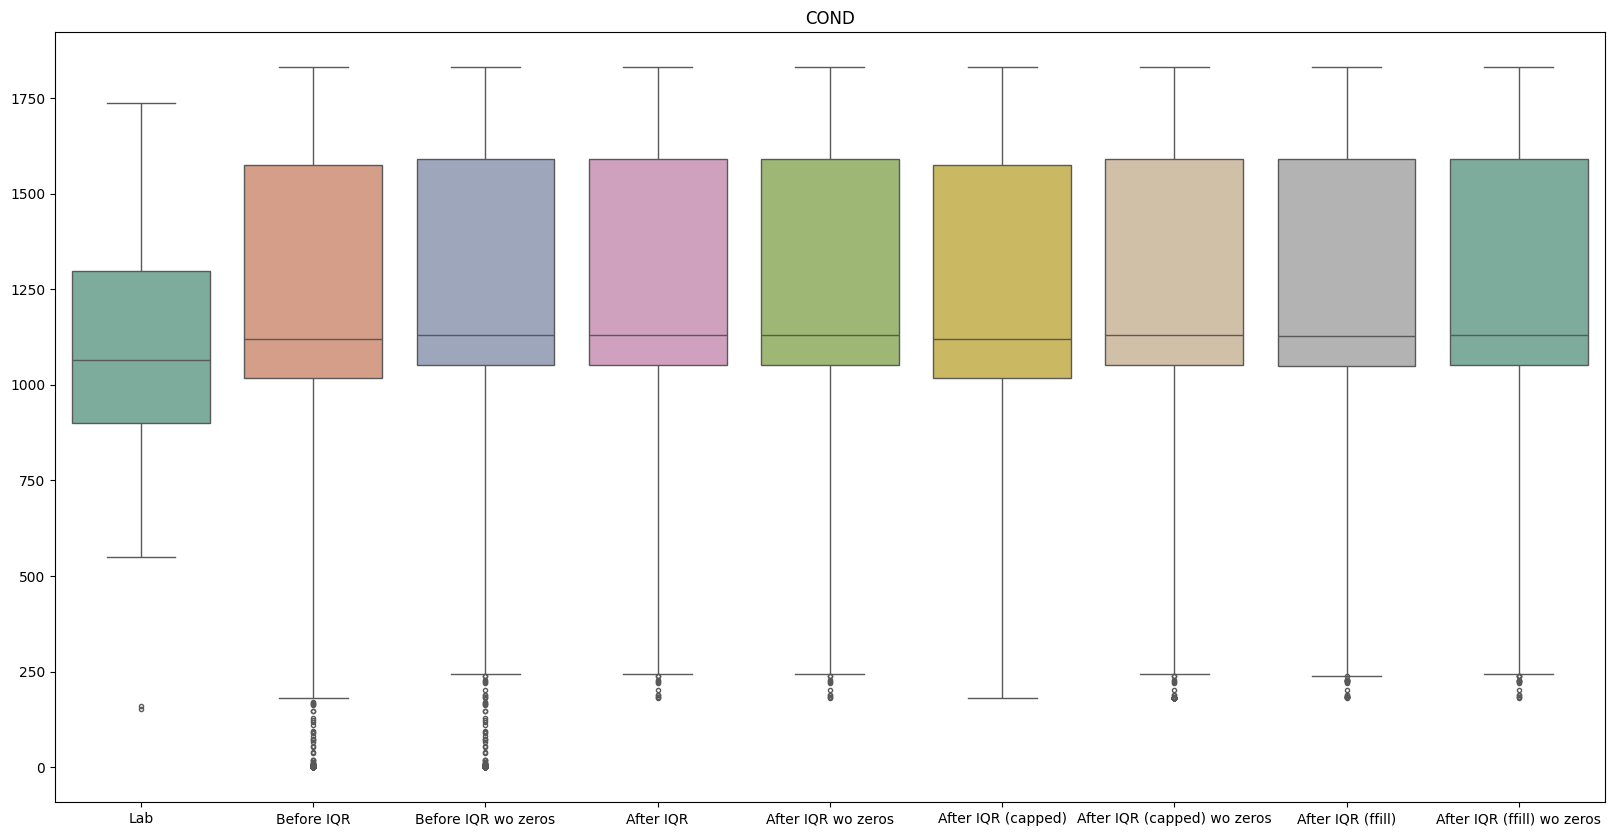

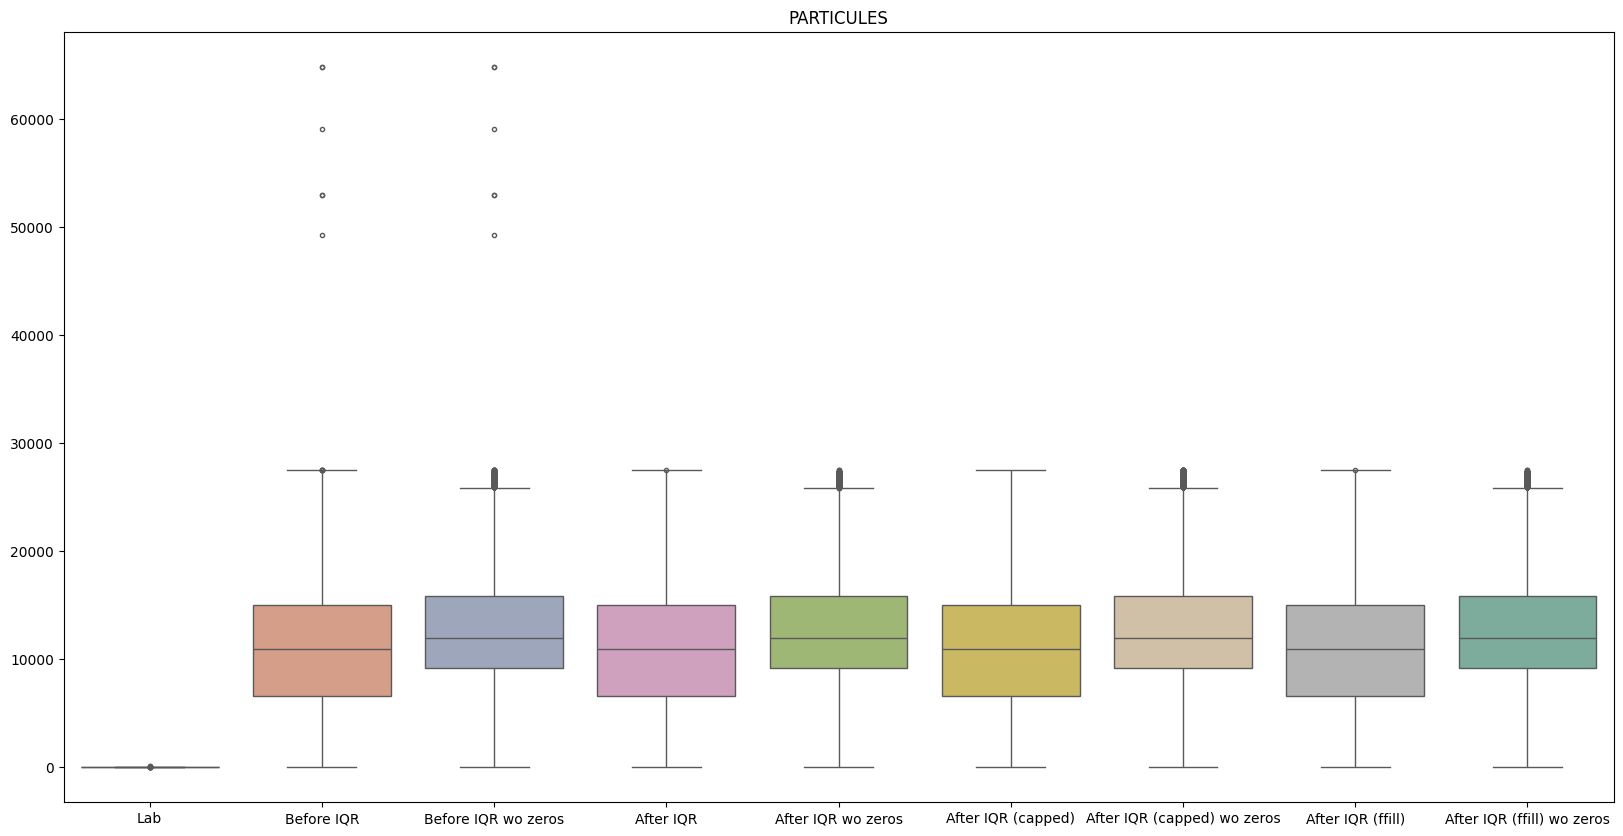

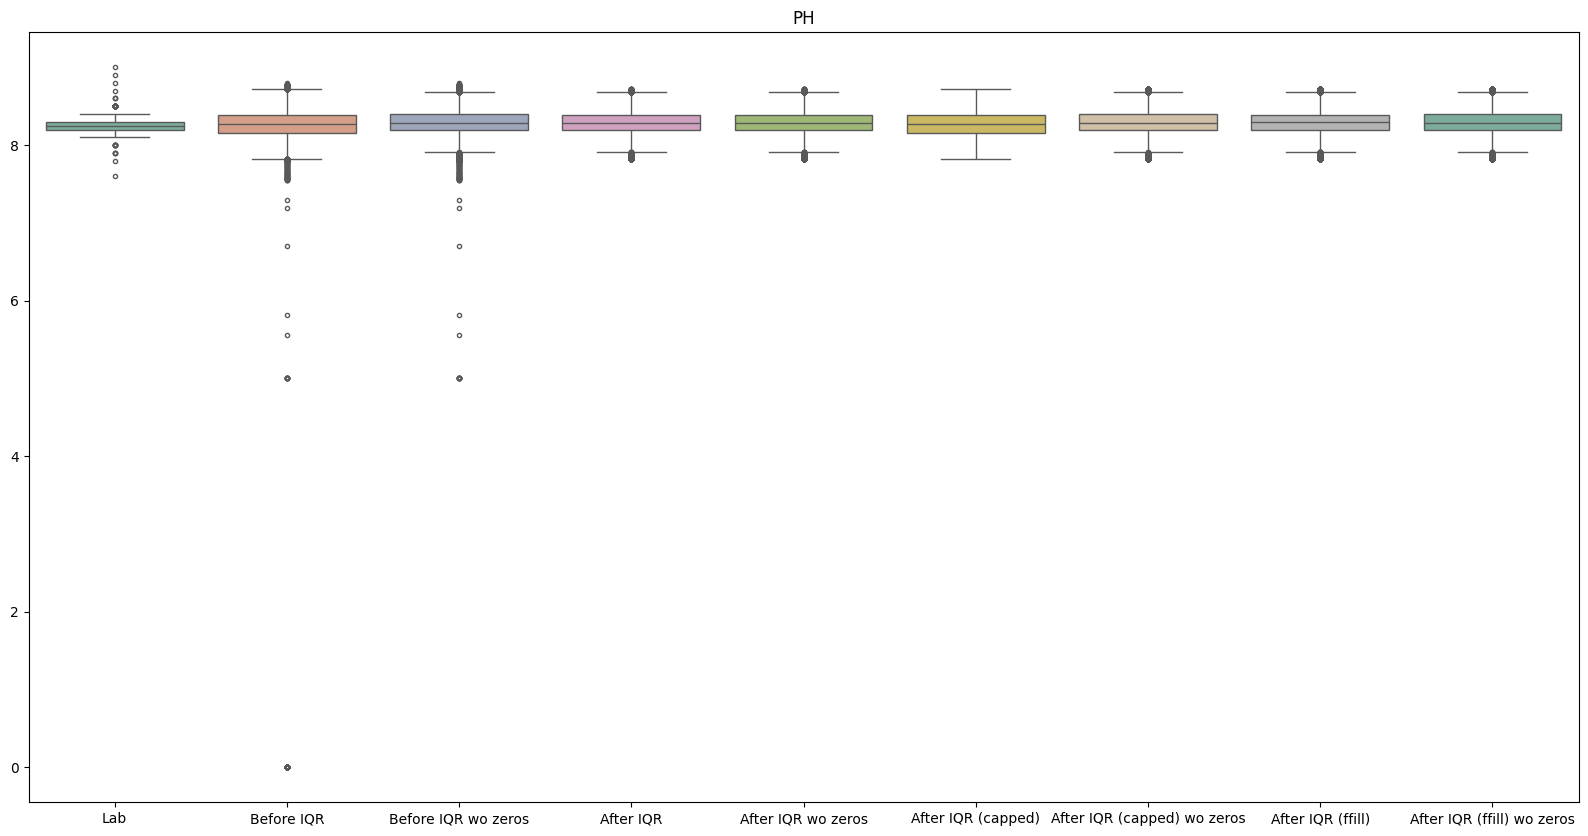

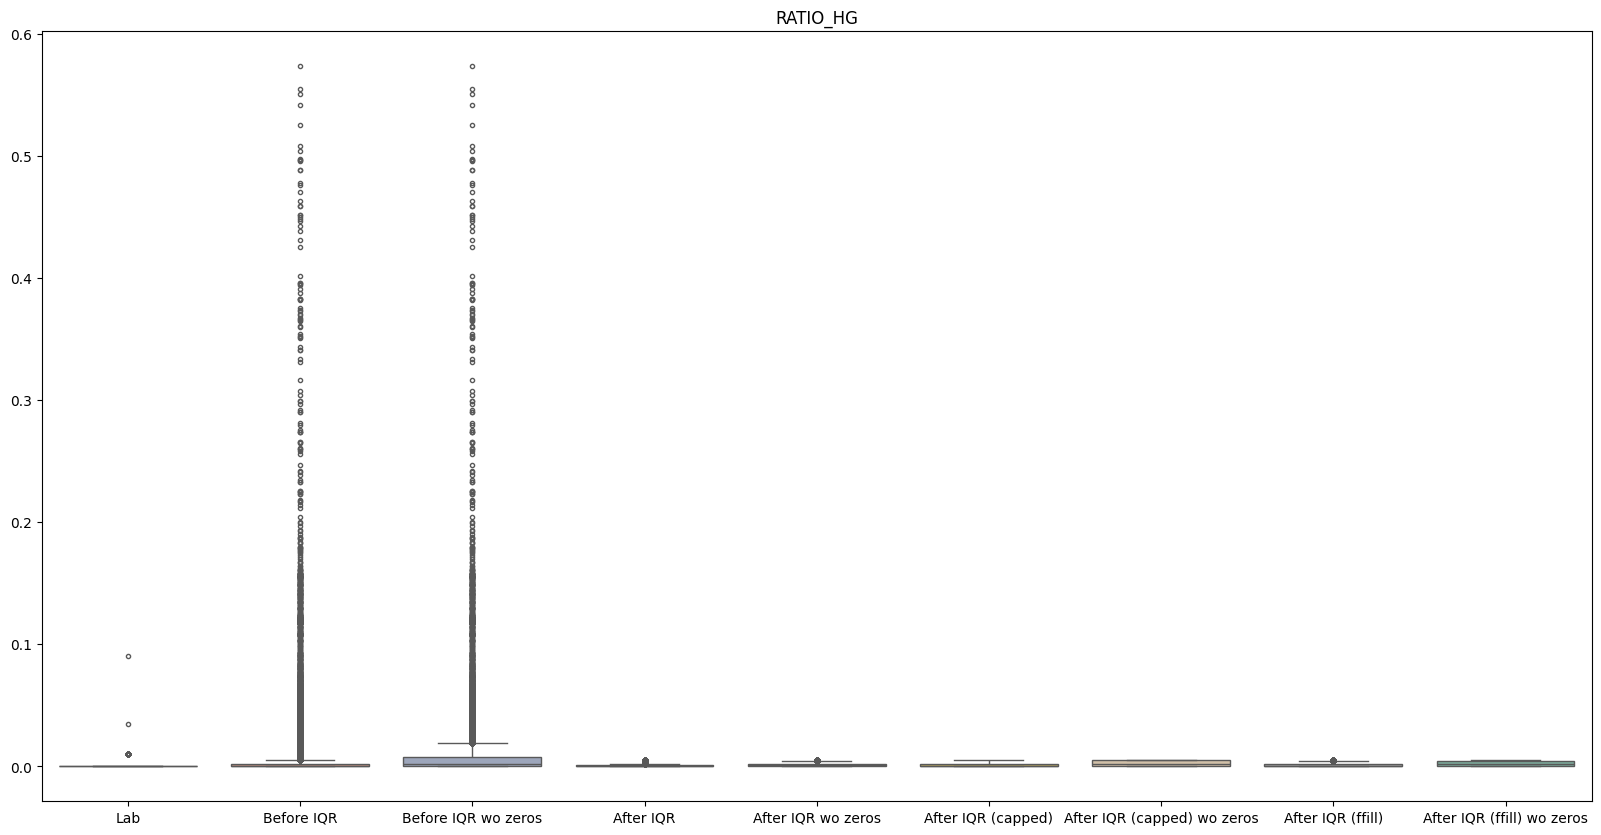

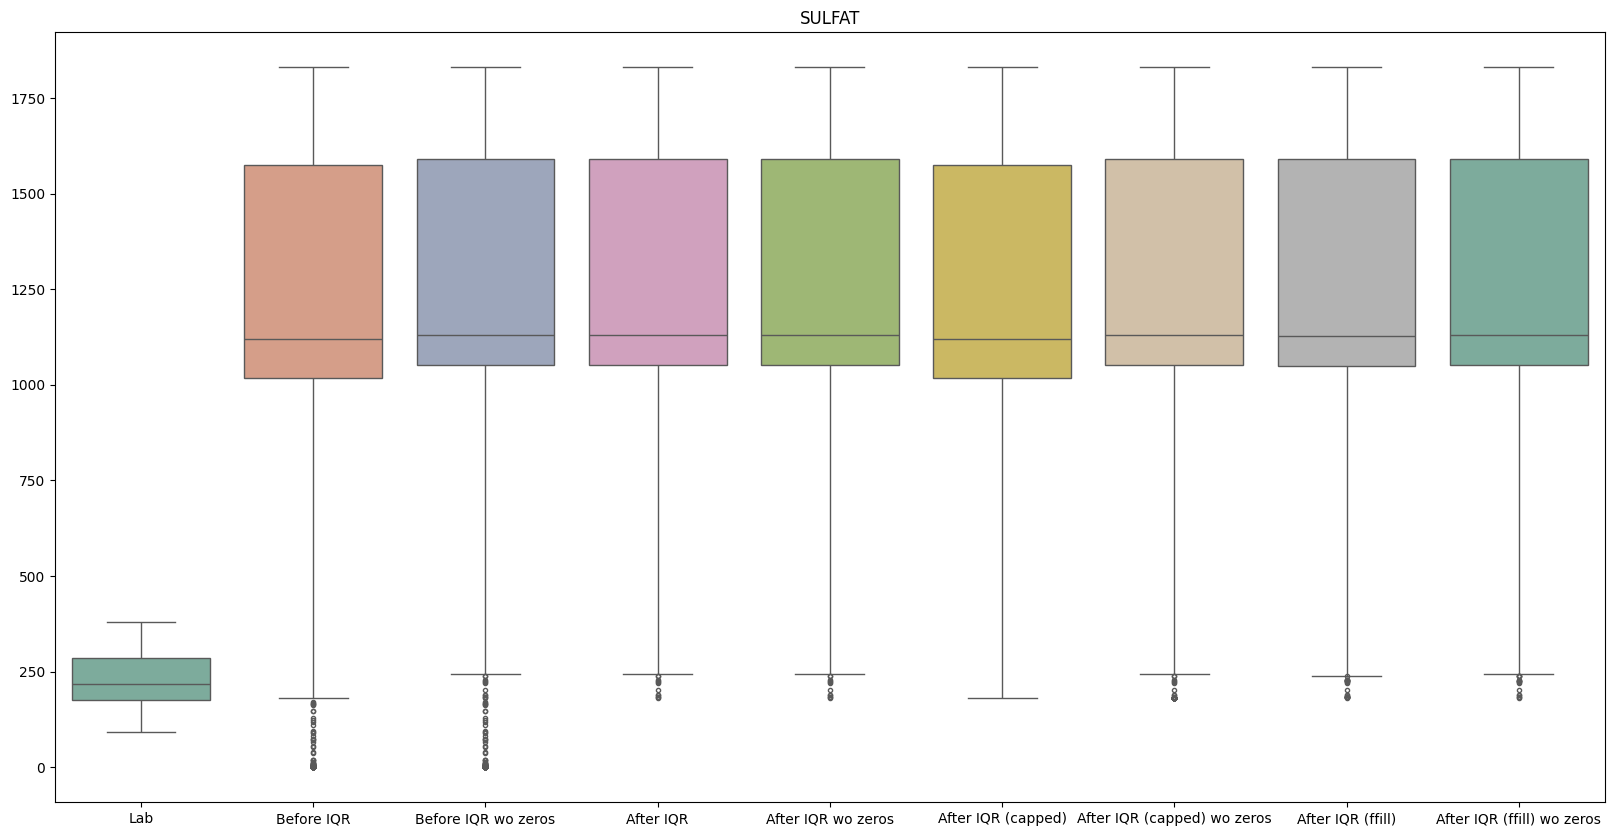

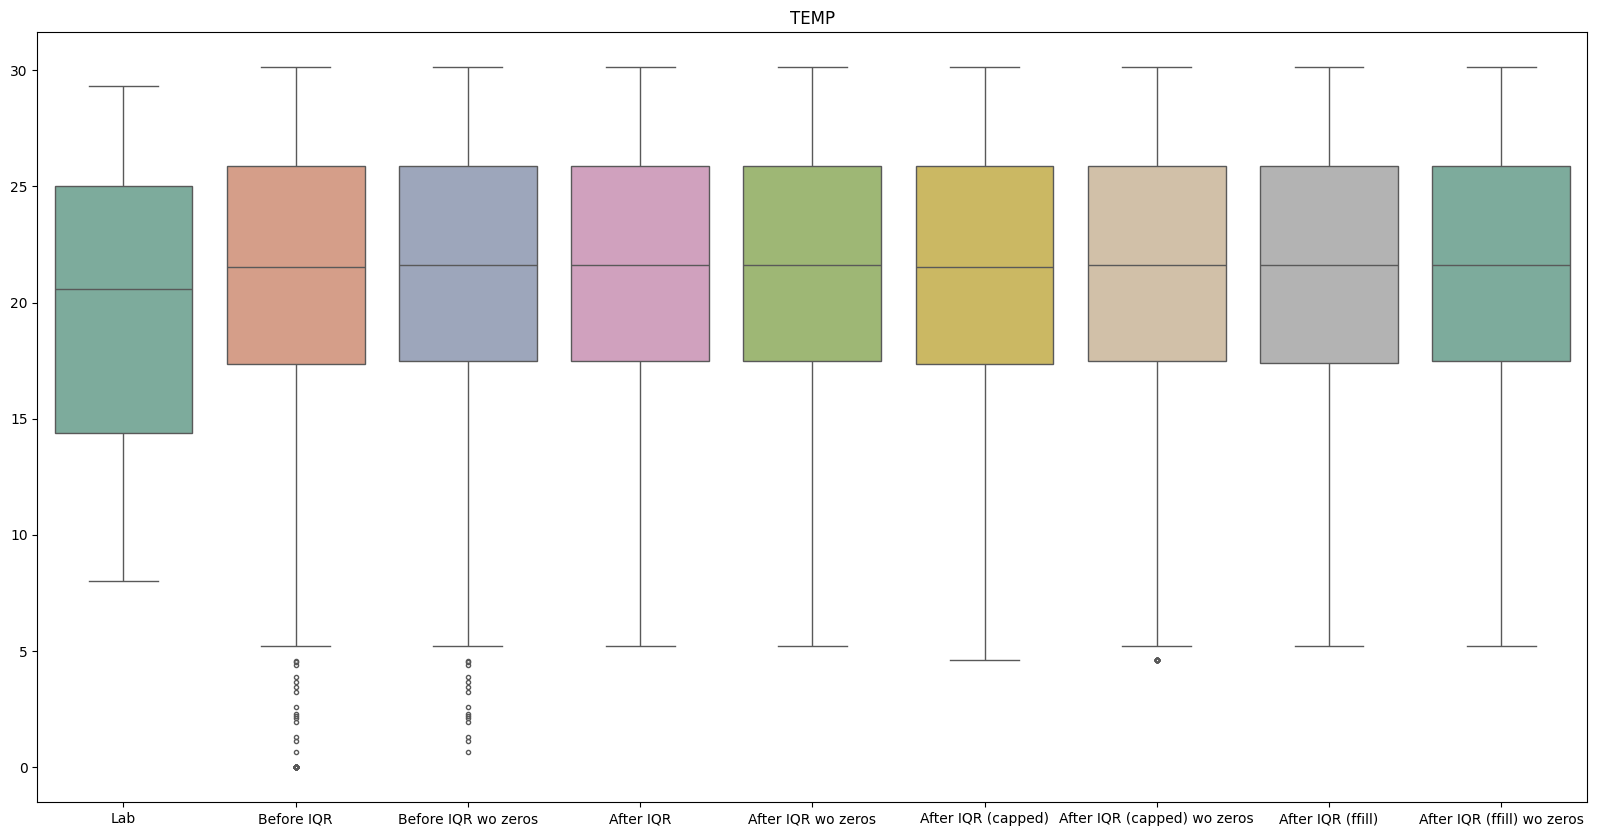

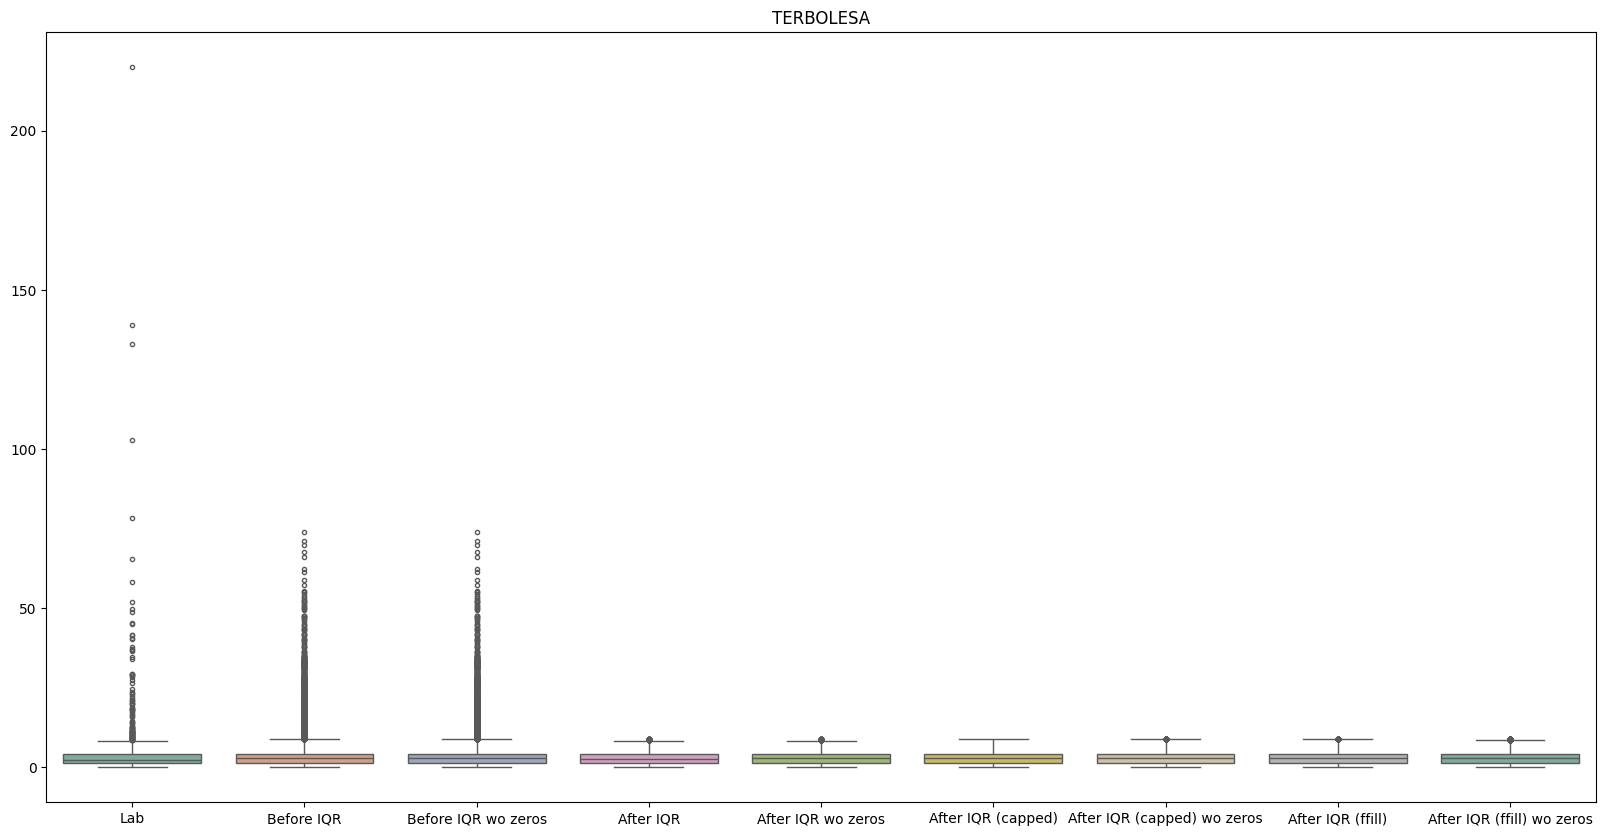

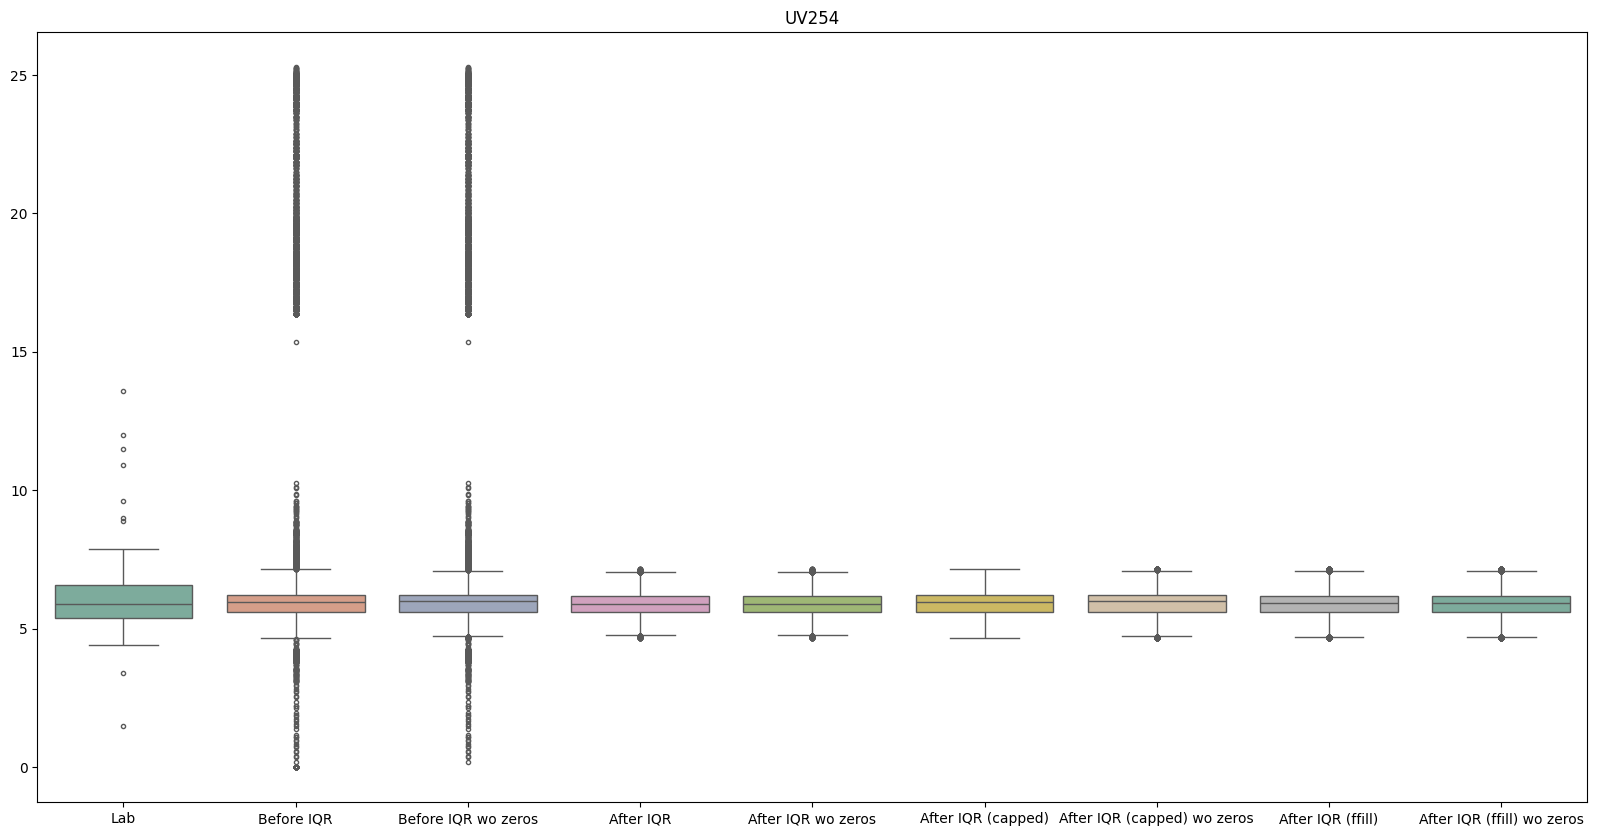

In [50]:
# Try combinations with and without zeros

# Outliers are removed using the IQR method
# NaNs are filled with the capped values

for lab_key, sensor_key in eb0_features_mapping.items():
    plt.figure(figsize=(20, 10))

    quartile1, quartile3 = eb0_sensor_df[sensor_key].quantile([0.25, 0.75])
    iqr = quartile3 - quartile1
    lower_bound = quartile1 - (1.5 * iqr)
    upper_bound = quartile3 + (1.5 * iqr)

    eb0_without_zeros = eb0_sensor_df[sensor_key][
        eb0_sensor_df[sensor_key] != 0
    ]

    # Create a temporary DataFrame with the column values before and after the IQR operation
    temp_df = pd.DataFrame(
        {
            "Lab": eb0_features_lab_df[lab_key],
            "Before IQR": eb0_sensor_df[sensor_key],
            "Before IQR wo zeros": eb0_without_zeros,
            "After IQR": eb0_sensor_df[sensor_key].apply(
                lambda x: x if (x > lower_bound and x < upper_bound) else None
            ),
            "After IQR wo zeros": eb0_without_zeros.apply(
                lambda x: x if (x > lower_bound and x < upper_bound) else None
            ),
            "After IQR (capped)": eb0_sensor_df[sensor_key].apply(
                lambda x: lower_bound
                if x < lower_bound
                else upper_bound
                if x > upper_bound
                else x
            ),
            "After IQR (capped) wo zeros": eb0_without_zeros.apply(
                lambda x: lower_bound
                if x < lower_bound
                else upper_bound
                if x > upper_bound
                else x
            ),
            "After IQR (ffill)": eb0_sensor_df[sensor_key]
            .apply(
                lambda x: x if (x > lower_bound and x < upper_bound) else None
            )
            .ffill(),
            "After IQR (ffill) wo zeros": eb0_without_zeros.apply(
                lambda x: x if (x > lower_bound and x < upper_bound) else None
            ).ffill(),
        }
    )

    # Plot the temporary DataFrame
    sns.boxplot(
        data=temp_df, palette="Set2", saturation=0.5, whis=1.5, fliersize=3
    )
    plt.title(sensor_key)
    plt.show()

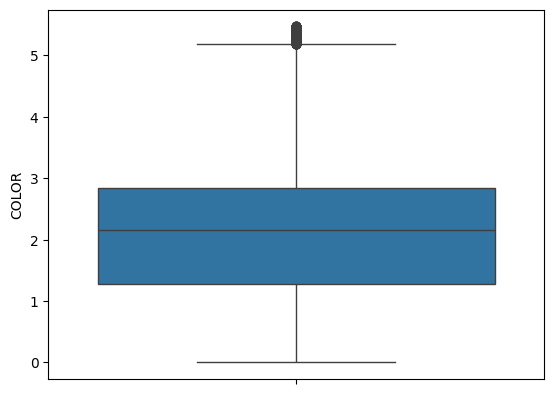

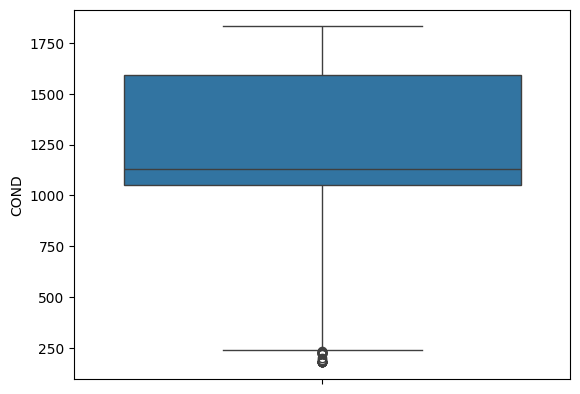

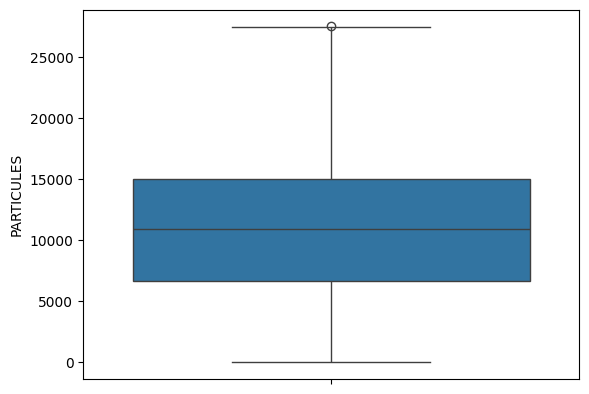

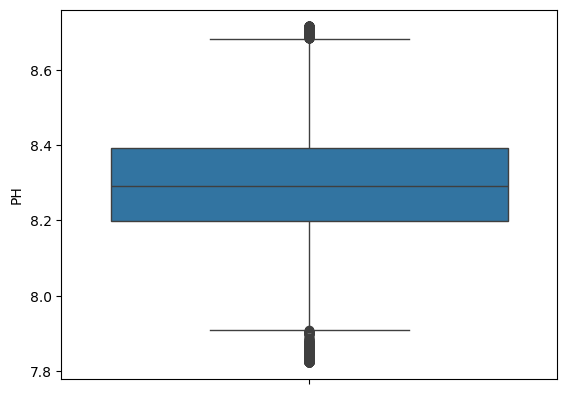

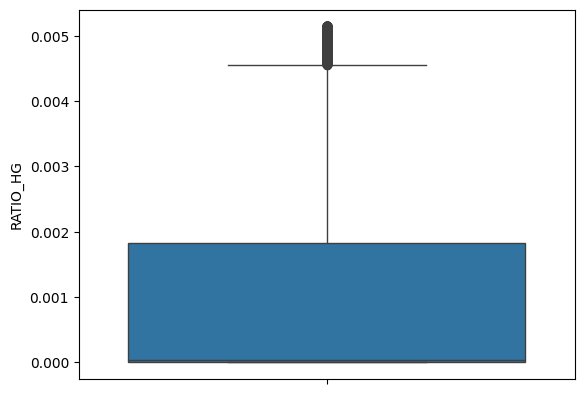

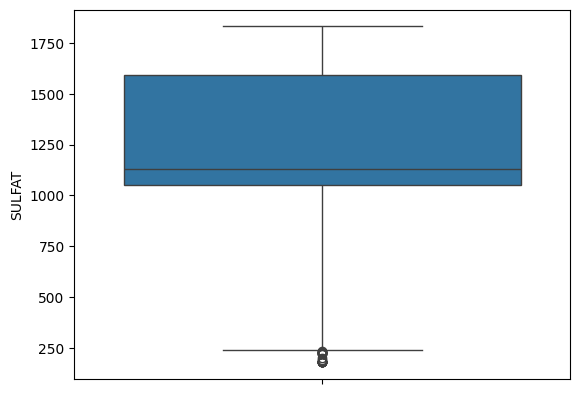

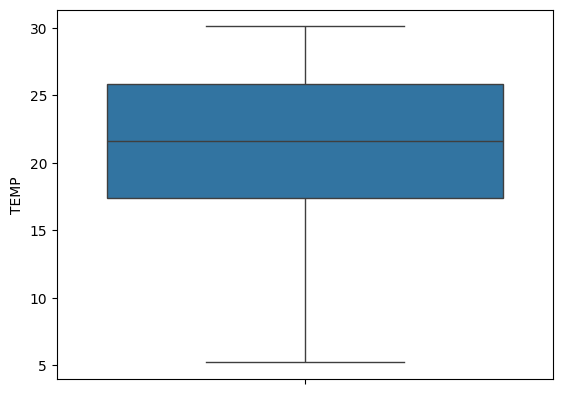

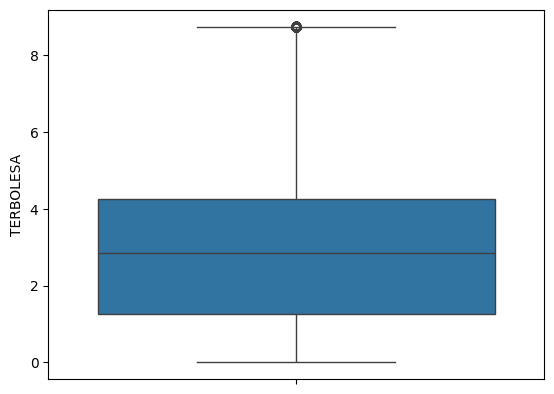

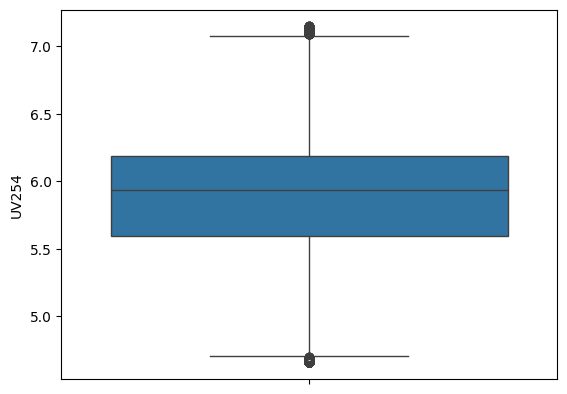

In [51]:
# Outliers are removed using the IQR method and NaNs are filled with ffill
for lab_key, sensor_key in eb0_features_mapping.items():
    plt.figure()

    quartile1, quartile3 = eb0_sensor_df[sensor_key].quantile([0.25, 0.75])
    iqr = quartile3 - quartile1
    lower_bound = quartile1 - (1.5 * iqr)
    upper_bound = quartile3 + (1.5 * iqr)

    eb0_sensor_df[sensor_key] = (
        eb0_sensor_df[sensor_key]
        .apply(lambda x: x if (x > lower_bound and x < upper_bound) else None)
        .ffill()
    )

    sns.boxplot(
        data=eb0_sensor_df[sensor_key],
    )

In [53]:
eb0_sensor_df.dropna(inplace=True)

### Histograms

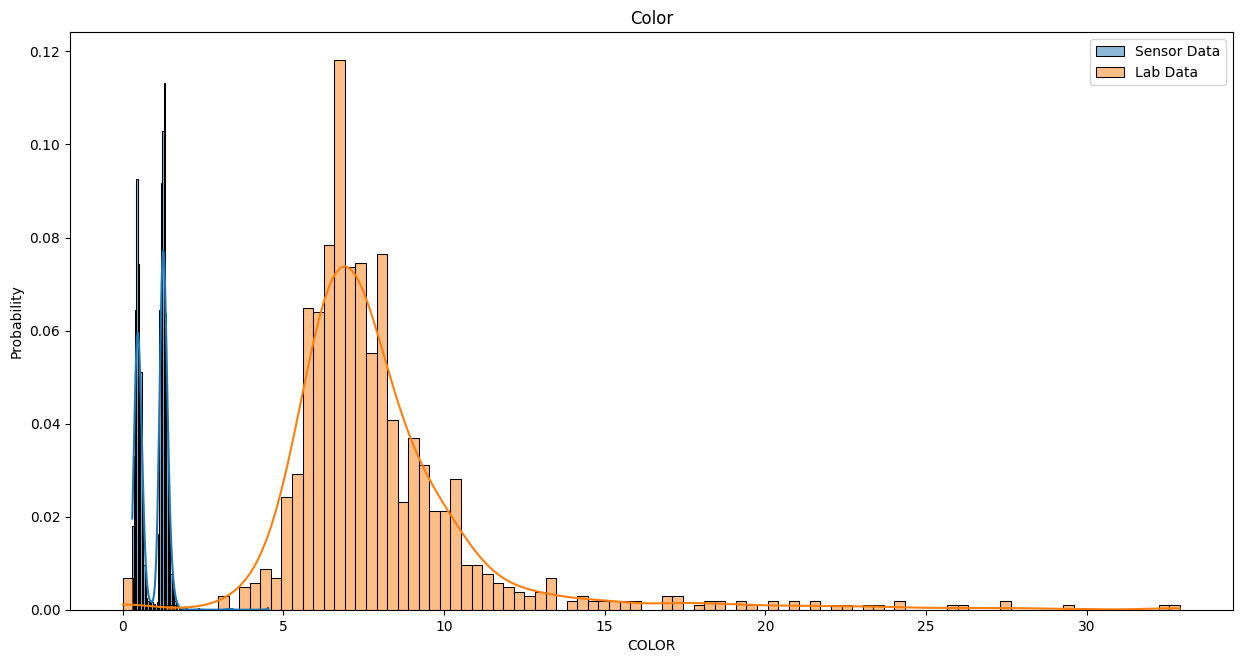

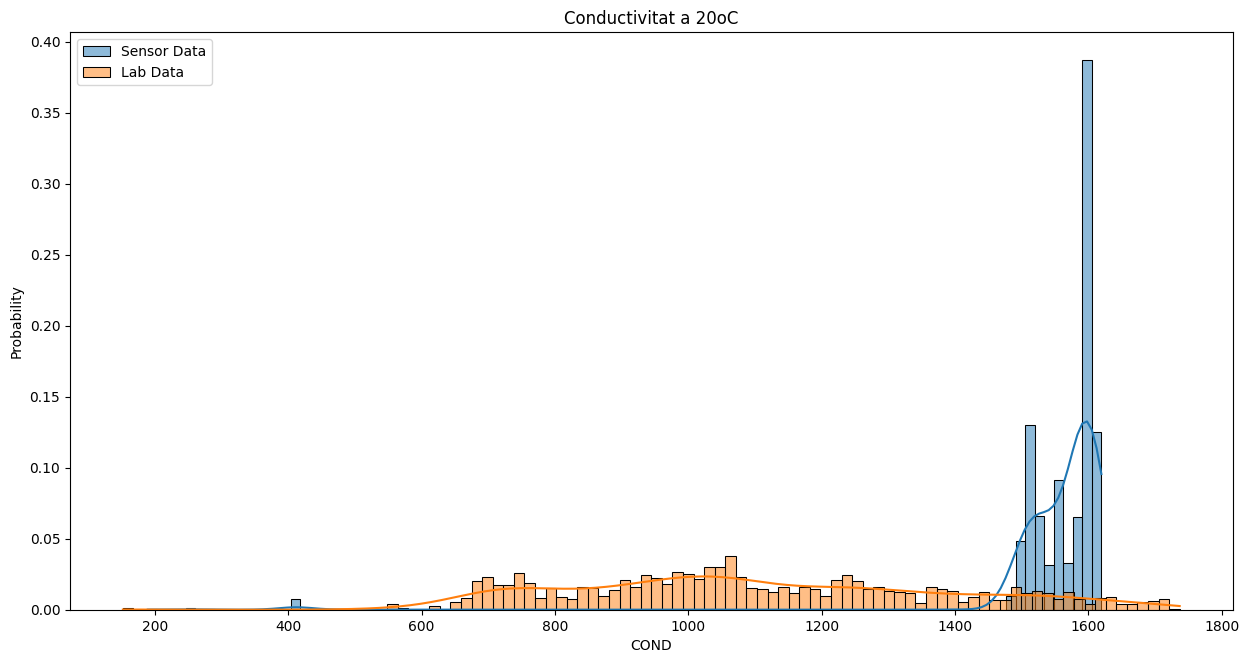

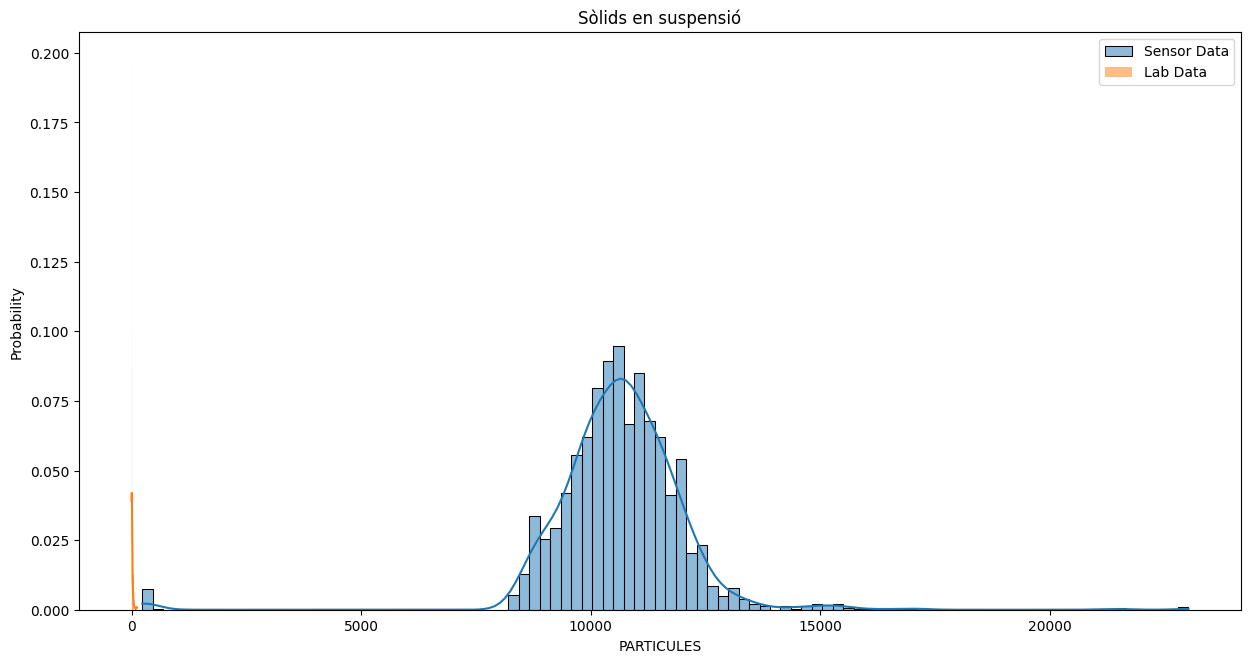

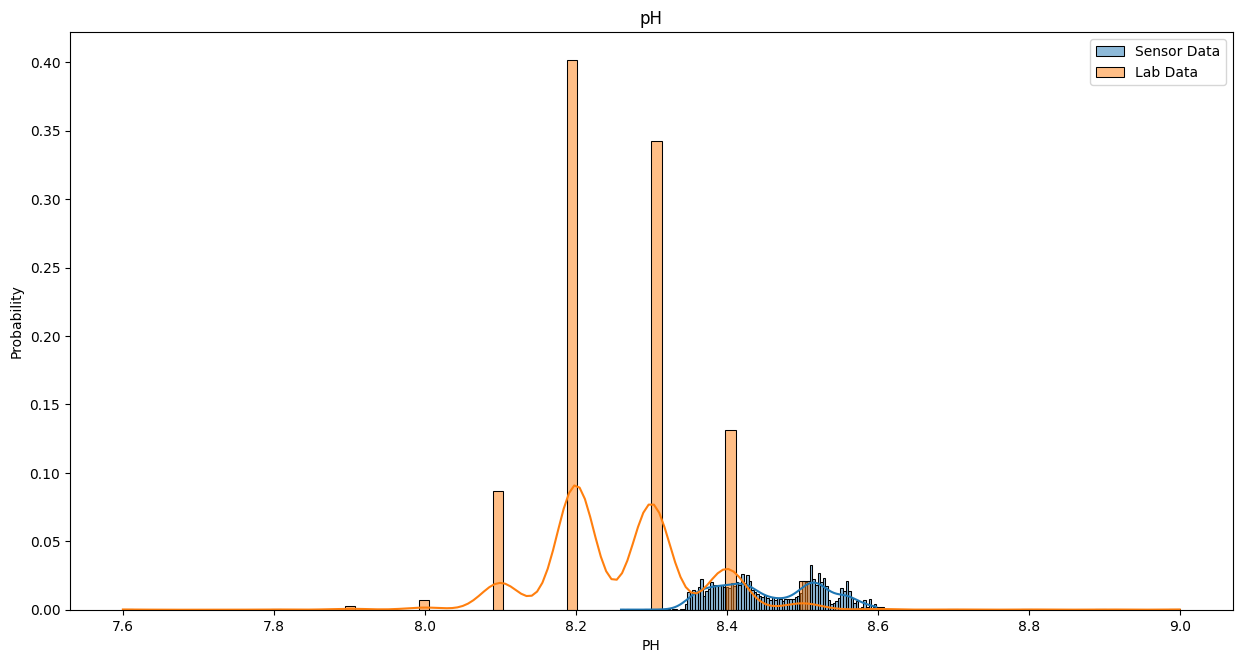

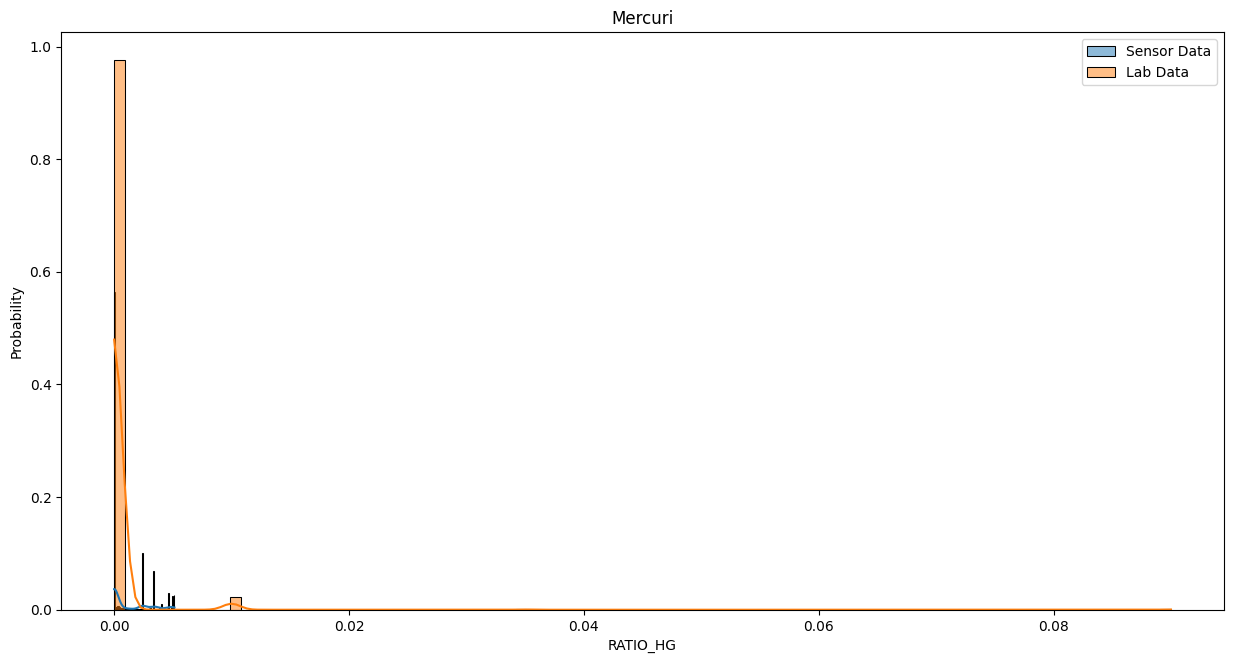

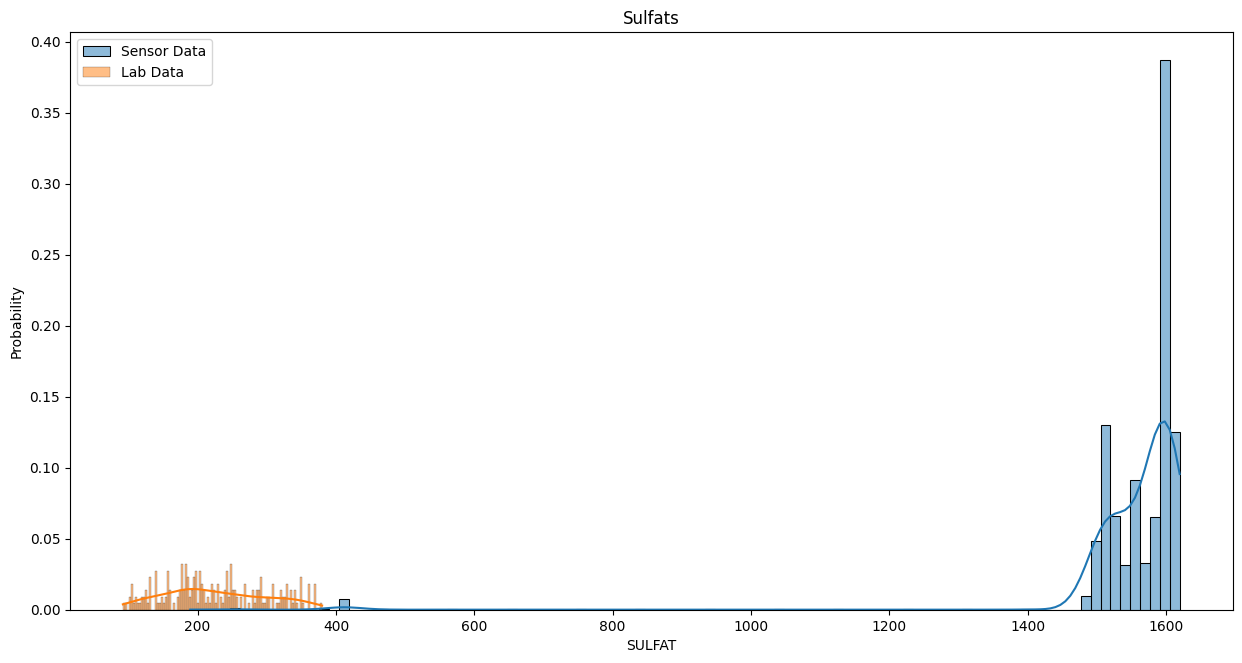

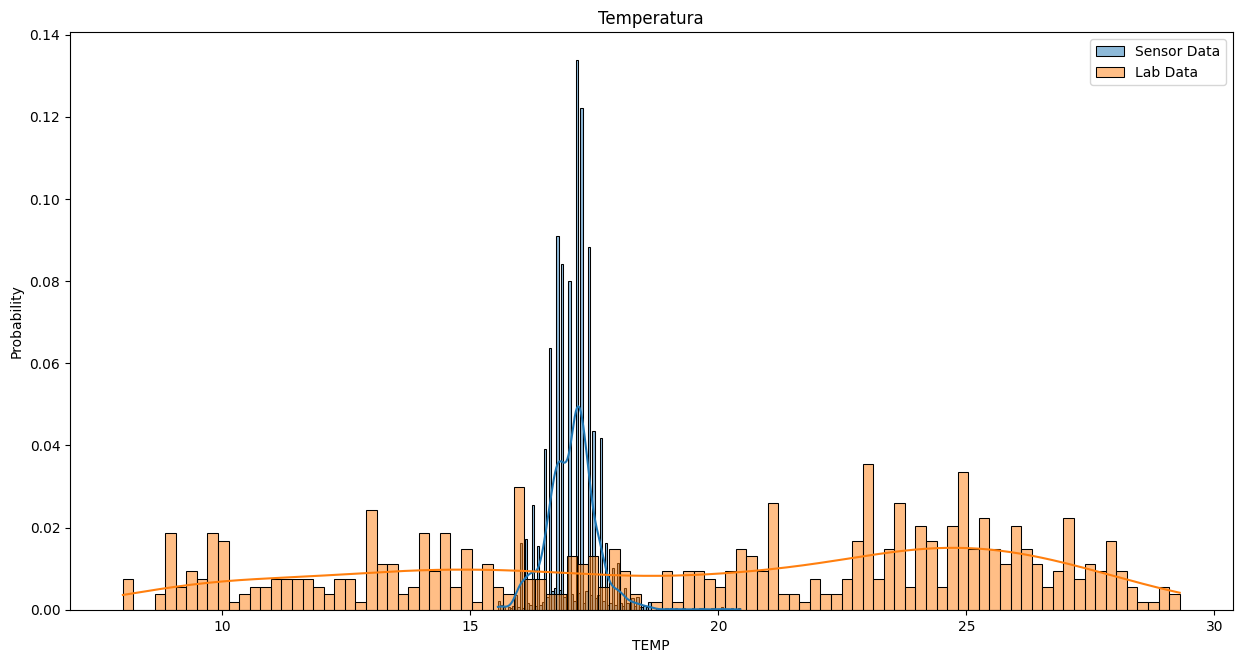

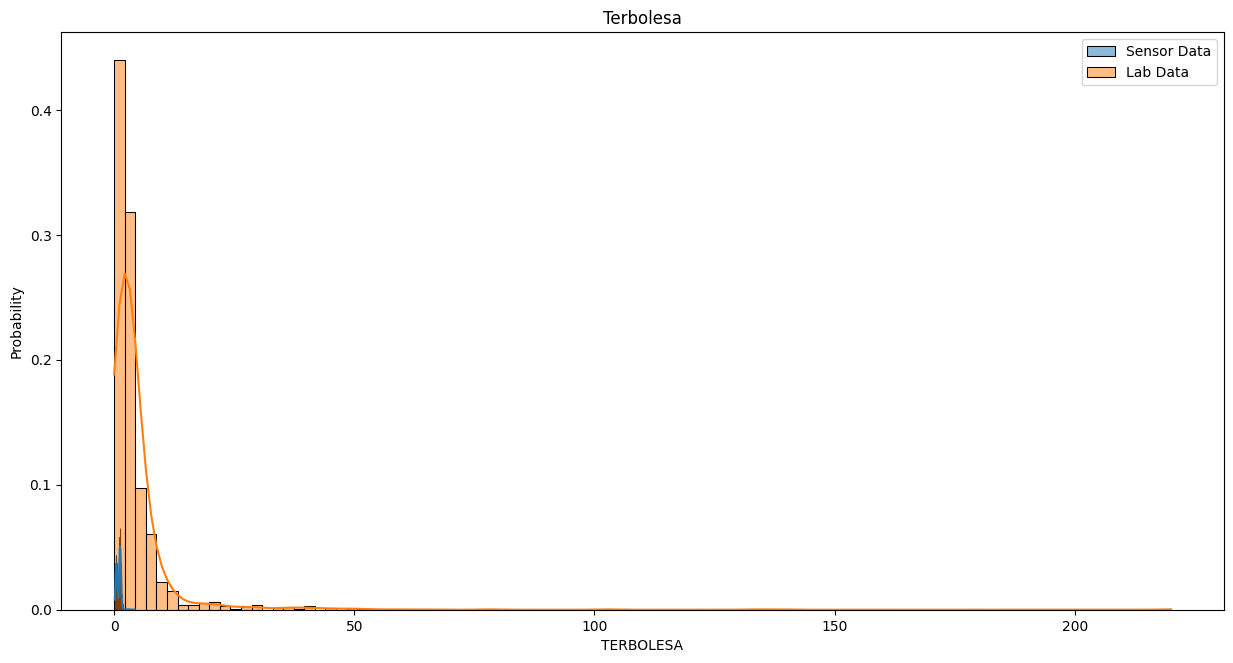

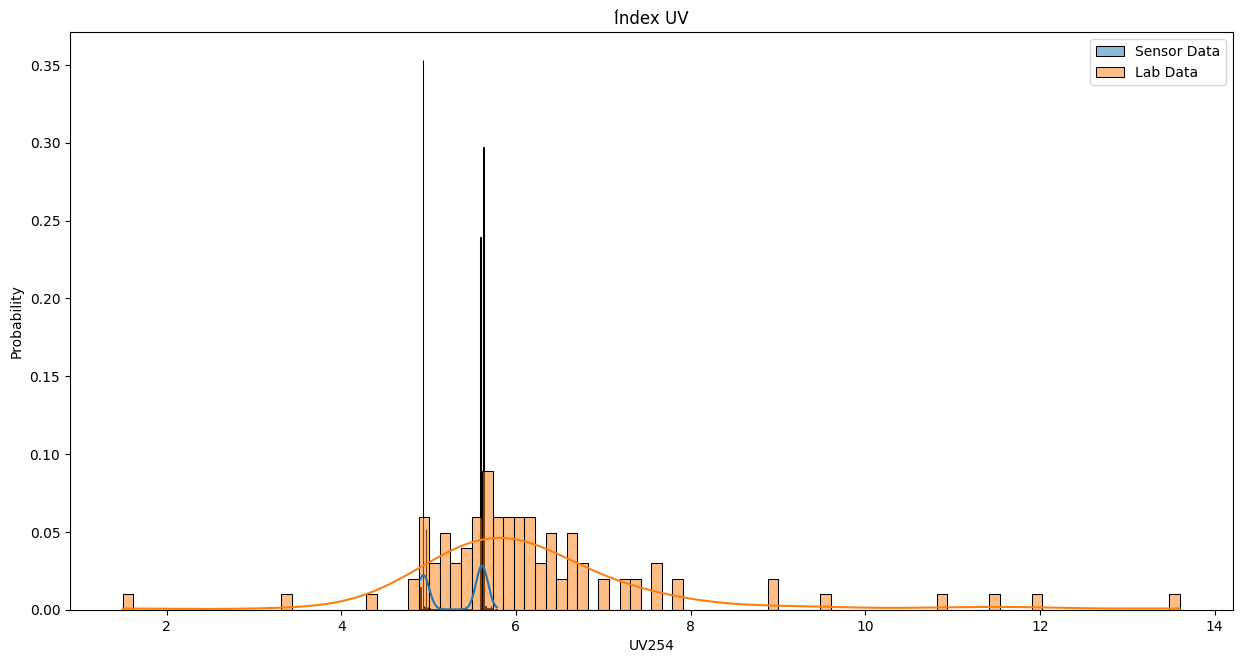

In [54]:
for lab_key, sensor_key in eb0_features_mapping.items():
    lab_key = normalize_string(lab_key)
    lab_df = eb0_features_lab_df[lab_key]
    sensor_df = eb0_sensor_df[sensor_key]

    # remove 0 values from sensor data
    # sensor_df = sensor_df[sensor_df != 0]

    if not lab_df.empty and not sensor_df.empty:
        plt.figure(figsize=(15, 7.5))

        # counts, bins, patches = plt.hist(
        #     lab_df,
        #     bins=100,
        #     color="blue",
        #     alpha=0.5,
        #     label="Lab",
        #     density=True,
        # )
        # # # Add counts as annotations
        # # for count, bin in zip(counts, bins):
        # #     plt.text(bin, count, str(int(count)))

        # plt.hist(
        #     sensor_df,
        #     bins=100,
        #     color="red",
        #     alpha=0.5,
        #     label="Sensor",
        #     density=True,
        # )

        sns.histplot(
            data=sensor_df,
            kde=True,
            bins=100,
            alpha=0.5,
            stat="probability",
            label="Sensor Data",
        )

        sns.histplot(
            data=lab_df,
            kde=True,
            bins=100,
            stat="probability",
            label="Lab Data",
        )

        plt.title(lab_key)
        plt.legend()
        plt.show()

        # The y-axis of a histplot with stat="probability" corresponds
        # to the probability that a value belongs to a certain bar.
        # The sum of the bar heights must be 1.

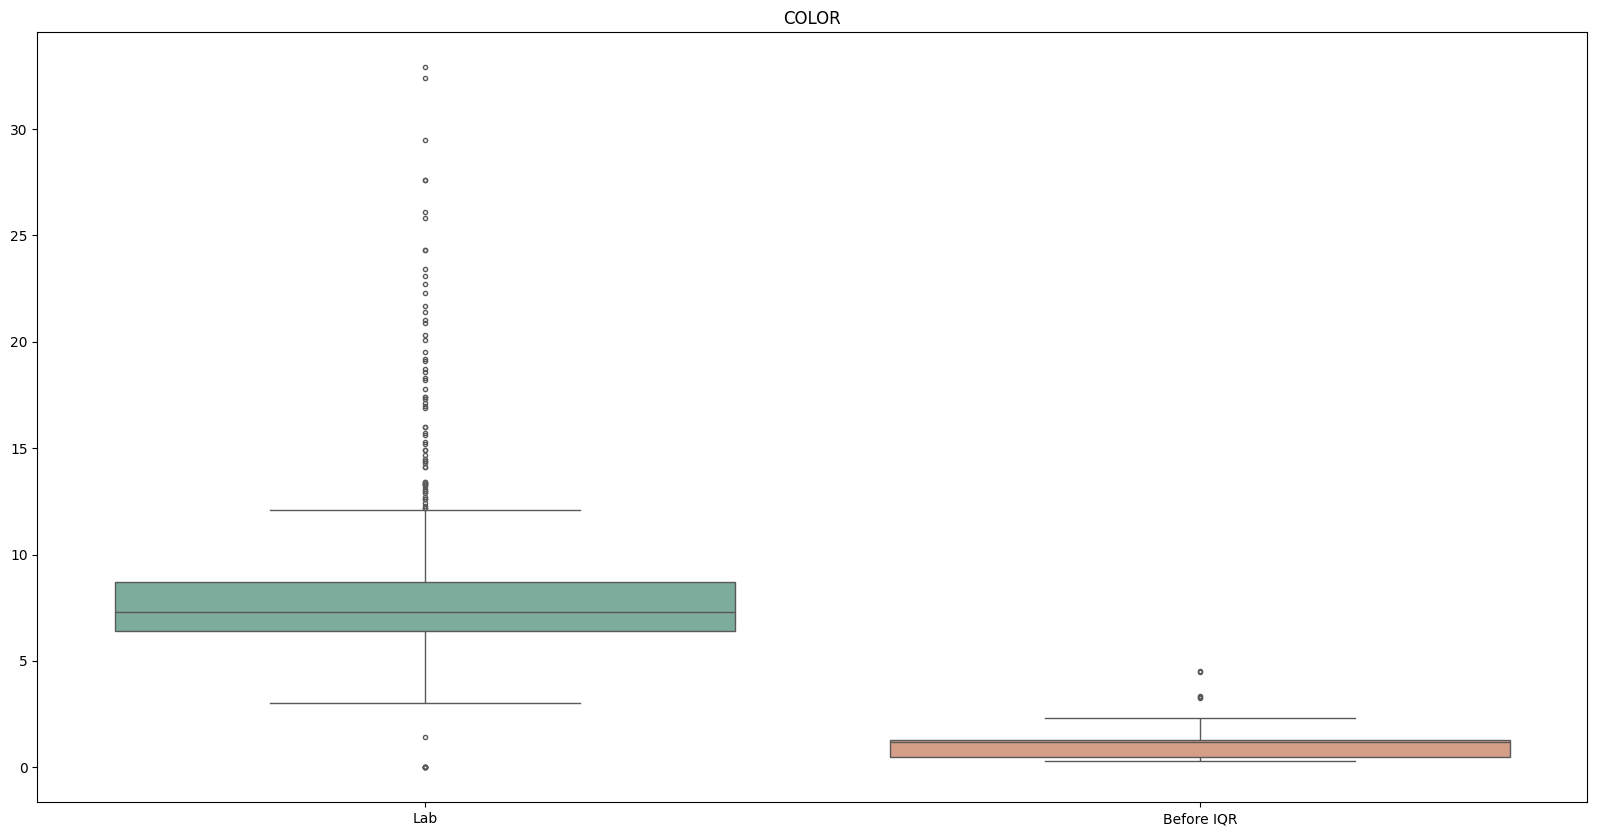

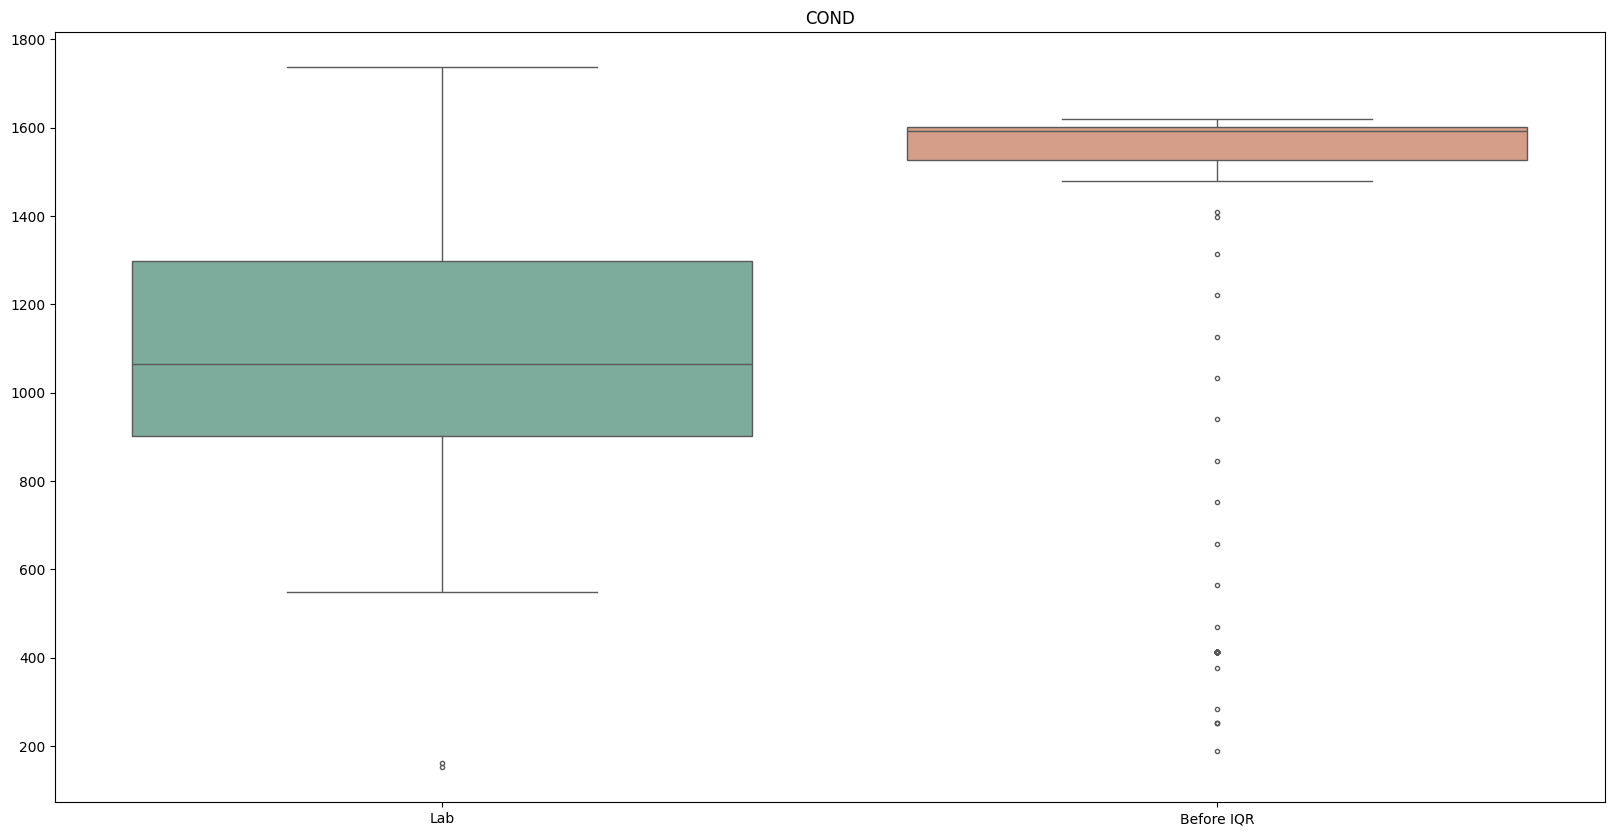

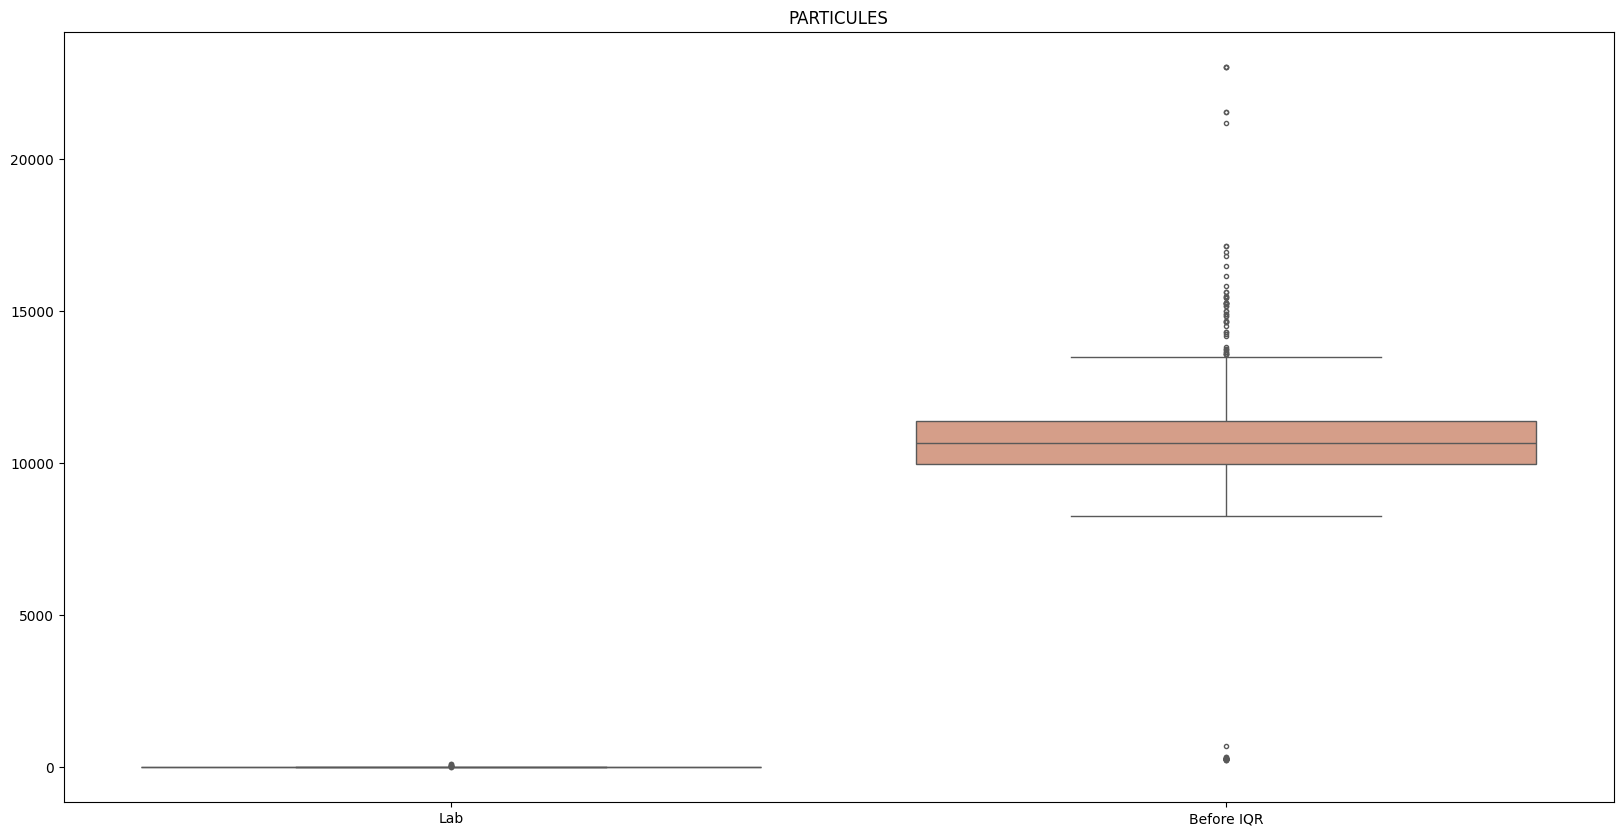

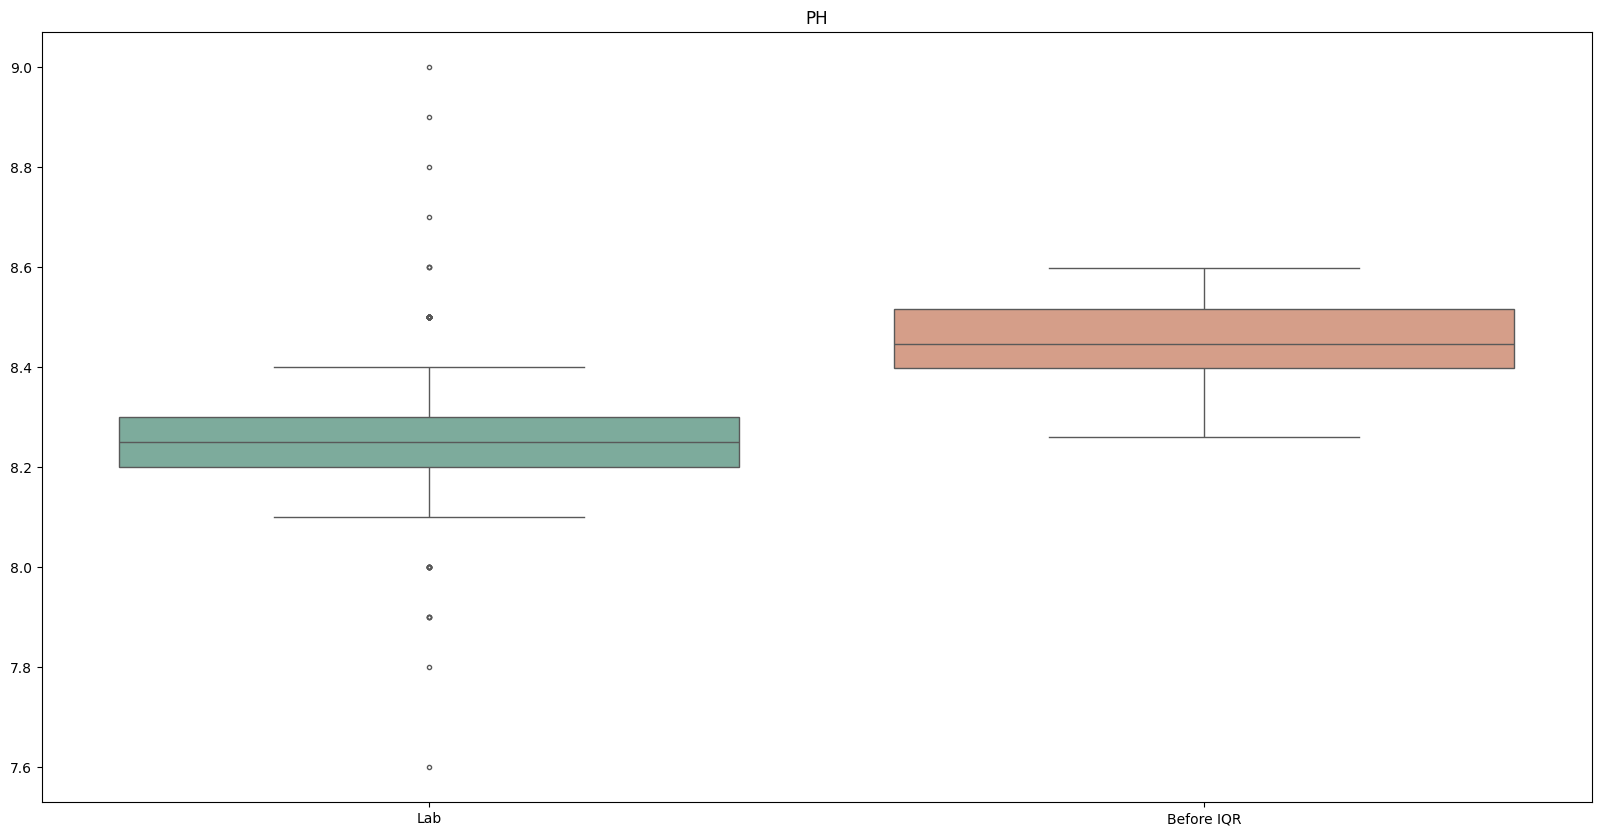

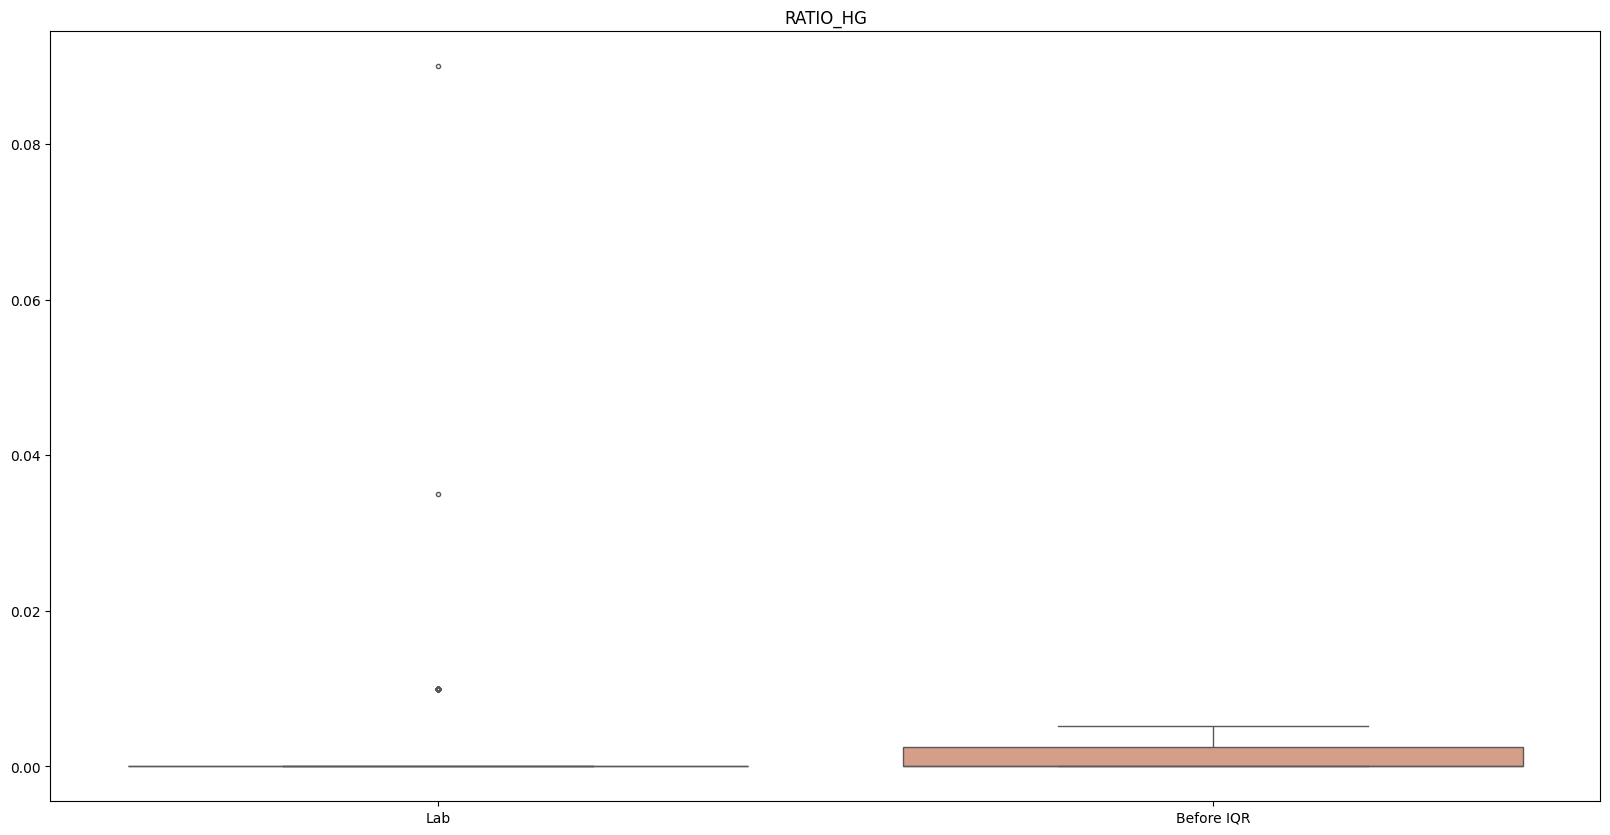

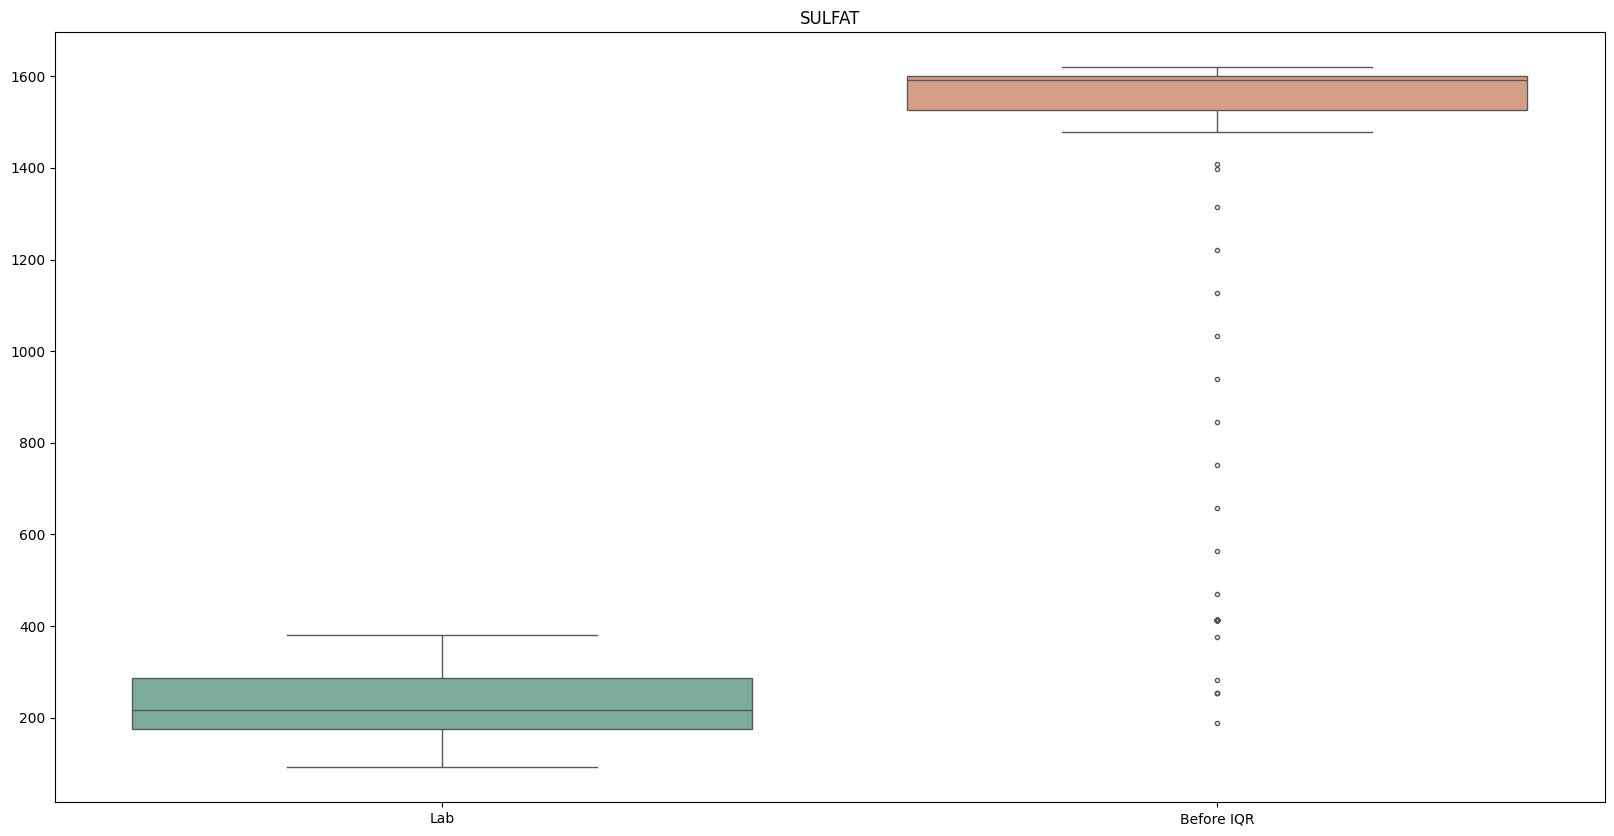

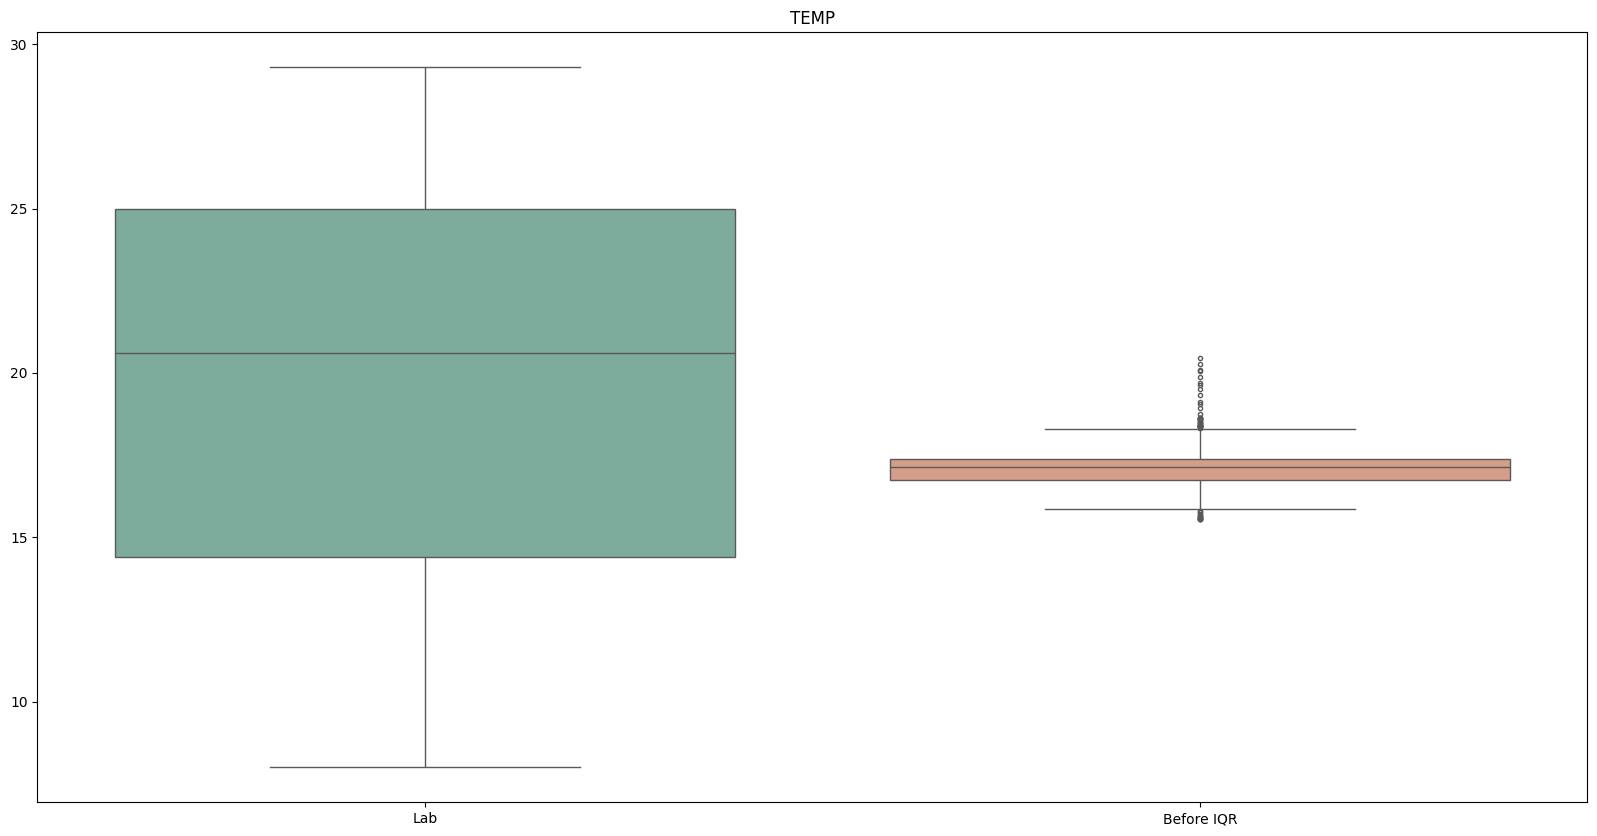

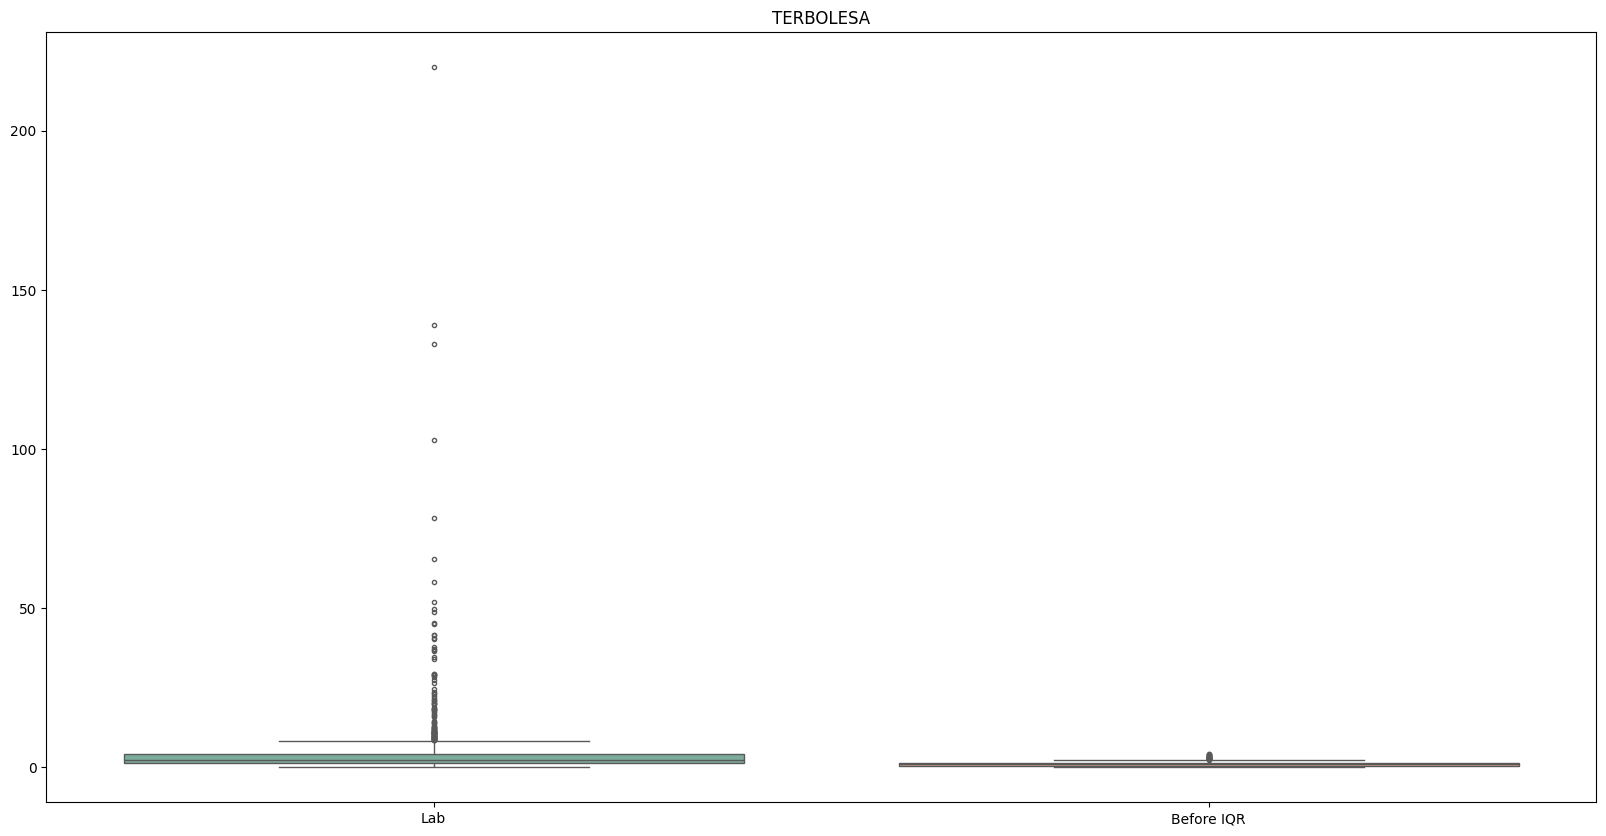

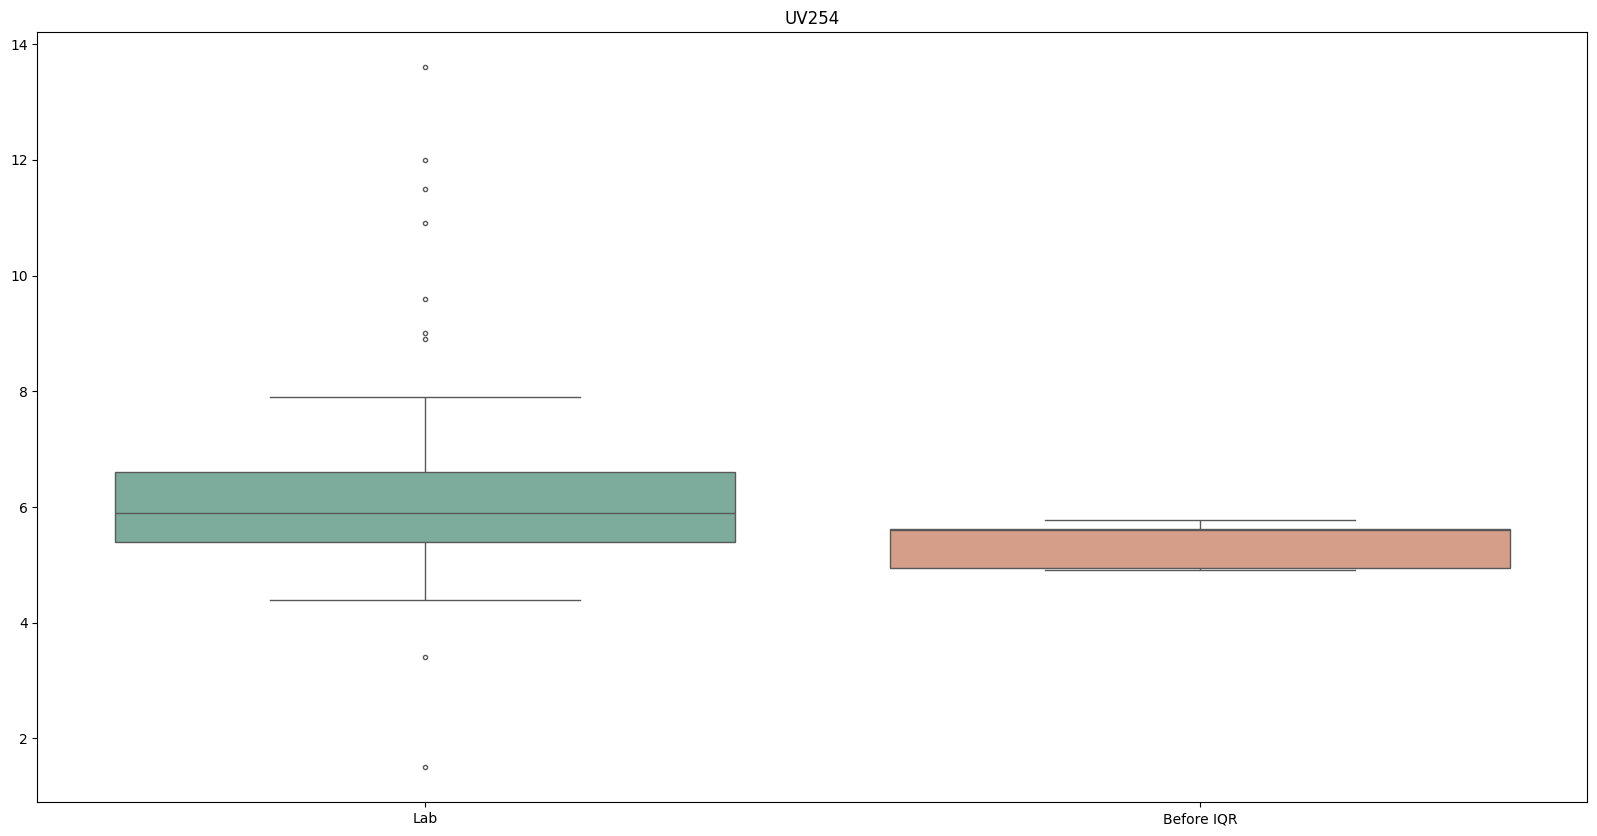

In [55]:
# Try combinations with and without zeros

# Outliers are removed using the IQR method
# NaNs are filled with the capped values

for lab_key, sensor_key in eb0_features_mapping.items():
    plt.figure(figsize=(20, 10))

    temp_df = pd.DataFrame(
        {
            "Lab": eb0_features_lab_df[lab_key],
            "Before IQR": eb0_sensor_df[sensor_key],
        }
    )

    # Plot the temporary DataFrame
    sns.boxplot(
        data=temp_df, palette="Set2", saturation=0.5, whis=1.5, fliersize=3
    )
    plt.title(sensor_key)
    plt.show()